In [2]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from models import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *
import datetime as dt
from simulation_func import *
import pandas as pd
import pickle as pkl
import os
import seaborn as sns
import scipy.stats as stats
import networkx as nx

- Load data from `Data` 

# Visualise population trajectories

- Starts with absolute biomass
- Then Abundance

## Loading Data

In [93]:
base_dir = '..\Data'
sample_number = 1
type = '\Asb'
t_type = '_t.npy'
Para_type ='_Para.pkl'
Rt_type = '_Rt.npy'
Ct_type = '_Ct.npy'
id_type = 'speciesID.npy'
file_name = f'\Abl_{sample_number}'

In [14]:
# start loading
repr_t = np.load(base_dir + type + file_name + file_name + t_type)
repr_Rt = np.load(base_dir + type + file_name + file_name + Rt_type)
repr_Ct = np.load('F:\Study\FYP\CellSizeBCAu\Data\Asb\Abl_1\Abl_1_Ct.npy')
para = pkl.load(open(base_dir + type + file_name + file_name + Para_type, 'rb'))
# idx = np.load(base_dir + type + file_name + file_name + id_type)

NameError: name 'base_dir' is not defined

In [42]:
repr_Ct = np.load('F:\Study\FYP\CellSizeBCAu\Data\\vexp\pair_1\Ct1.npy')
repr_Rt = np.load('F:\Study\FYP\CellSizeBCAu\Data\\vexp\pair_1\Rt1.npy')
para = pkl.load(open('F:\Study\FYP\CellSizeBCAu\Data\\vexp\pair_1\para1.pkl', 'rb'))
repr_t = np.load('F:\Study\FYP\CellSizeBCAu\Data\\vexp\pair_1\\t1.npy')

In [43]:
repr_Ct.shape
repr_Rt.shape

(100, 10000)

## without early termination

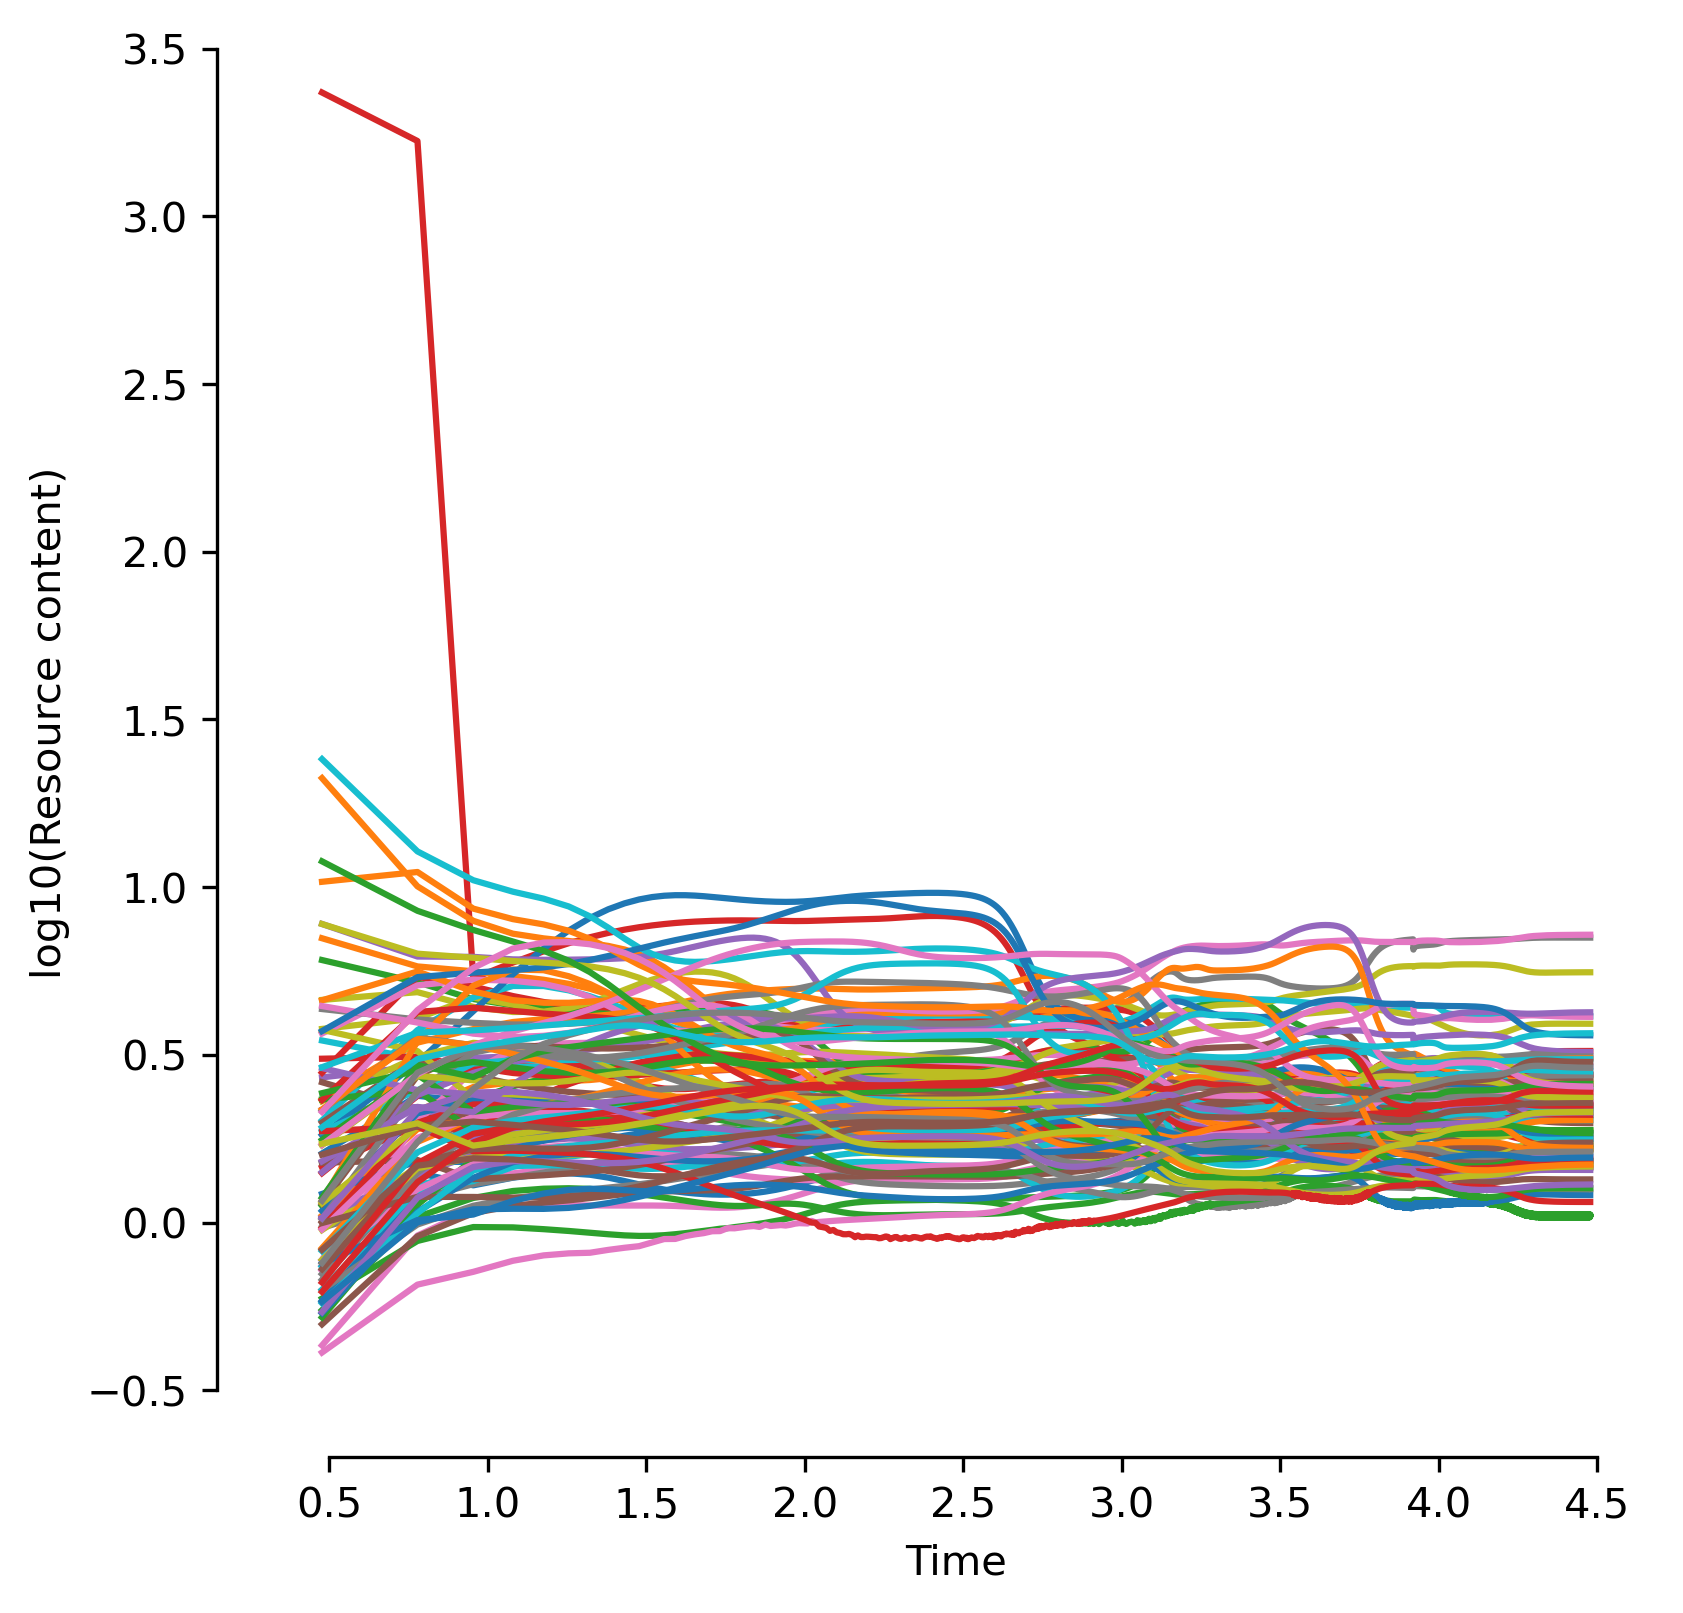

In [44]:
# plot species biomass trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.M):
    sns.lineplot(x=np.log10(repr_t), y=np.log10(repr_Rt[i, :]))
plt.xlabel('Time')
plt.ylabel('log10(Resource content)')
sns.despine(offset=10, trim=True)

Number of Species is 50
Number of resource is 100
number of remaining species is 31


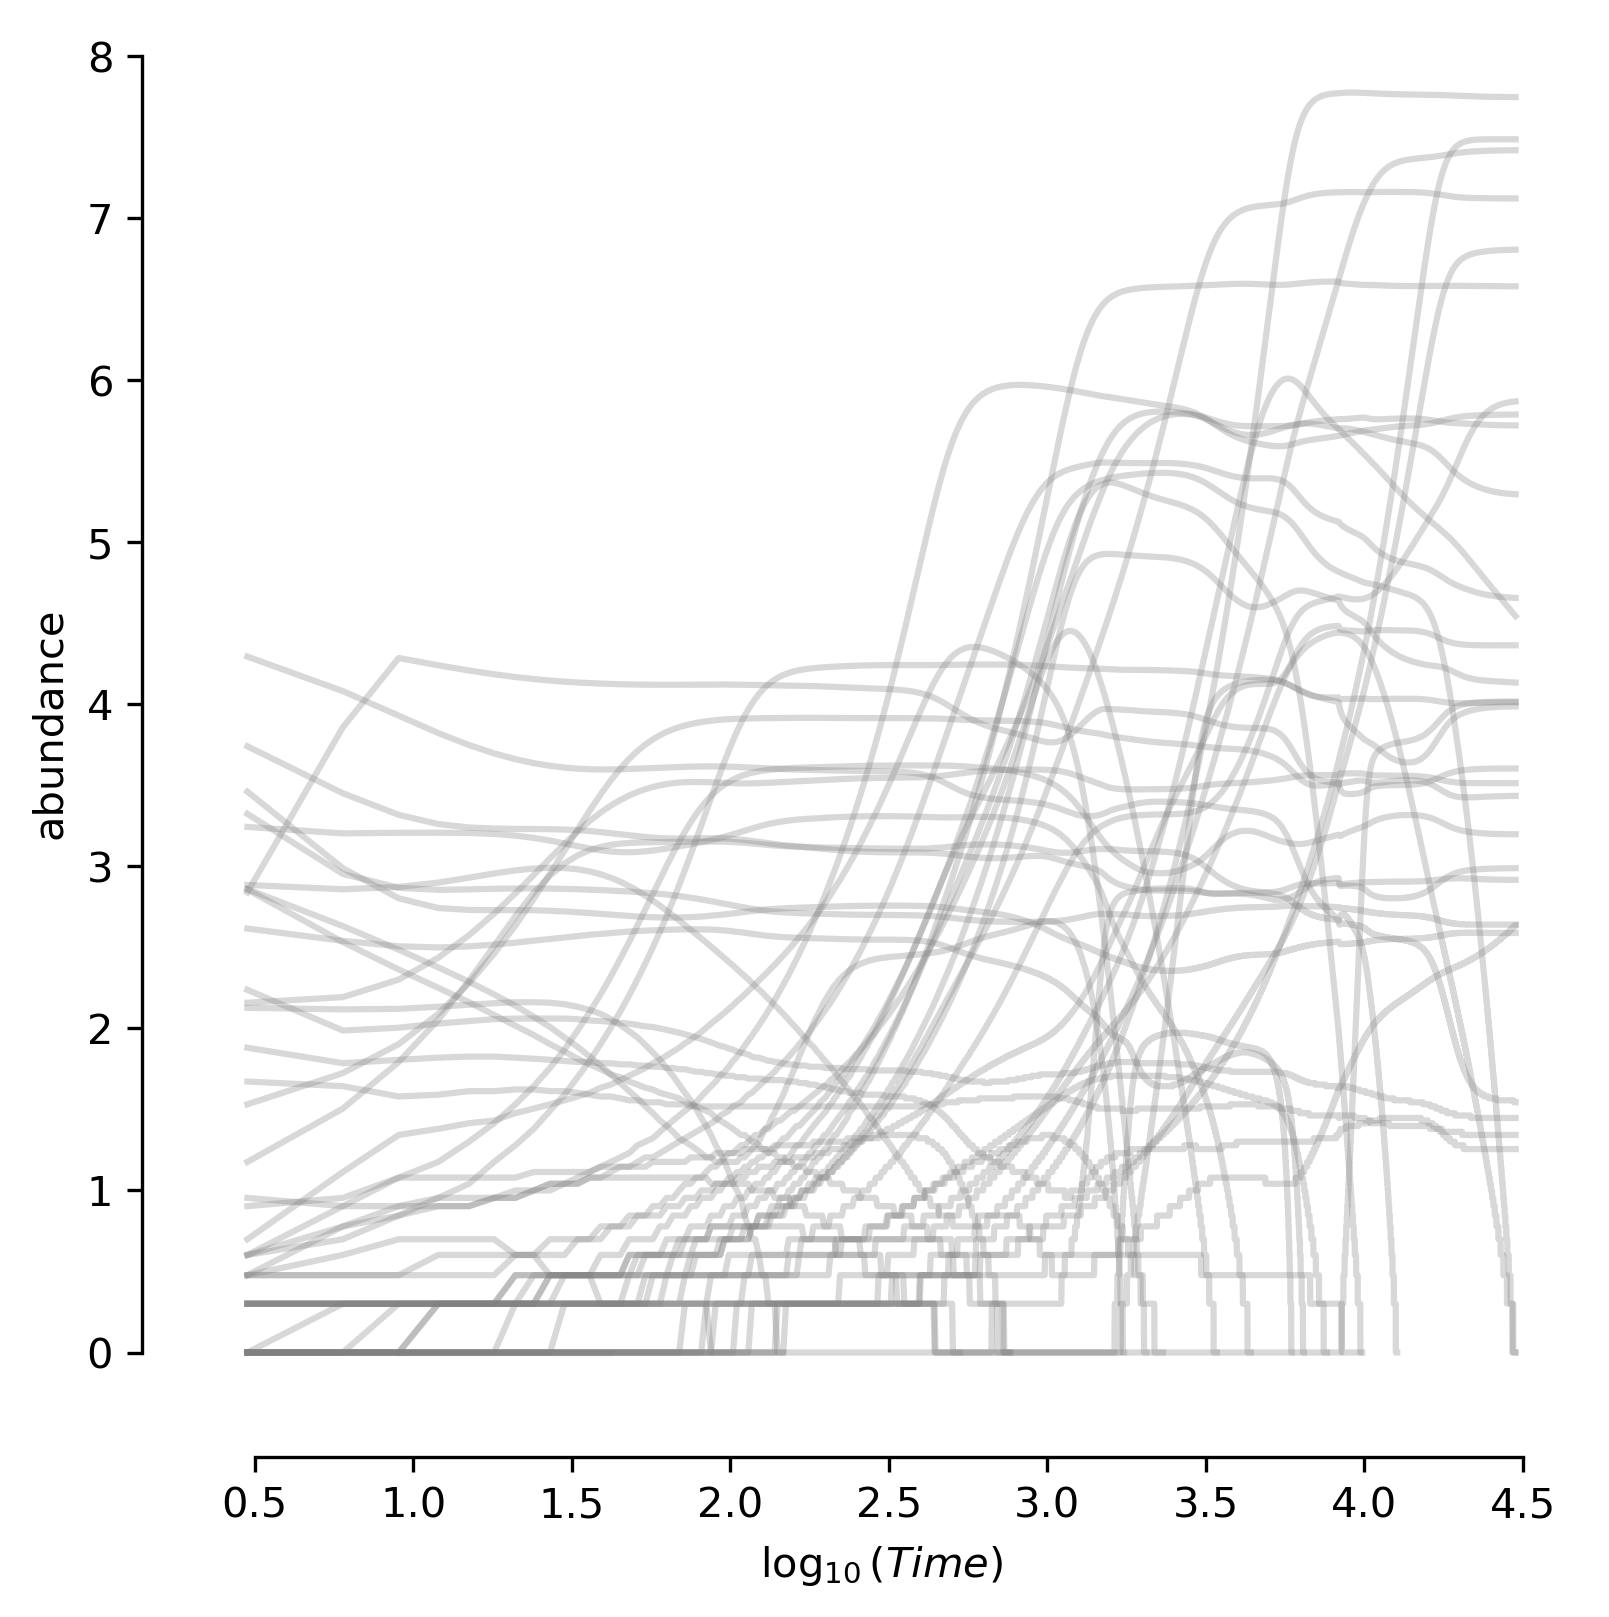

In [45]:
# get average mass
avgm = para.avgm.reshape(para.avgm.shape[0])

# calulate abundance
for j in range(len(repr_Ct[1, :])):
    repr_Ct[:, j] = repr_Ct[:, j]/avgm

# if abundance smaller than 1 then the species extincts
for i in range(len(repr_Ct[:, 1])):
    temp = repr_Ct[i, :]
    temp[temp < 1] = 0
    repr_Ct[i, :] = np.rint(temp)

# plot species biomass trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.N):
    sns.lineplot(x=np.log10(repr_t), y=np.log10(repr_Ct[i, :]), color='grey', alpha=0.3)
plt.xlabel('$\log_{10} ({Time})$')
plt.ylabel('abundance')
sns.despine(offset=10, trim=True)
print(f'Number of Species is {para.N}')
print(f'Number of resource is {para.M}')
print(f'number of remaining species is {len(repr_Ct[repr_Ct[:, -1]>0, -1])}')

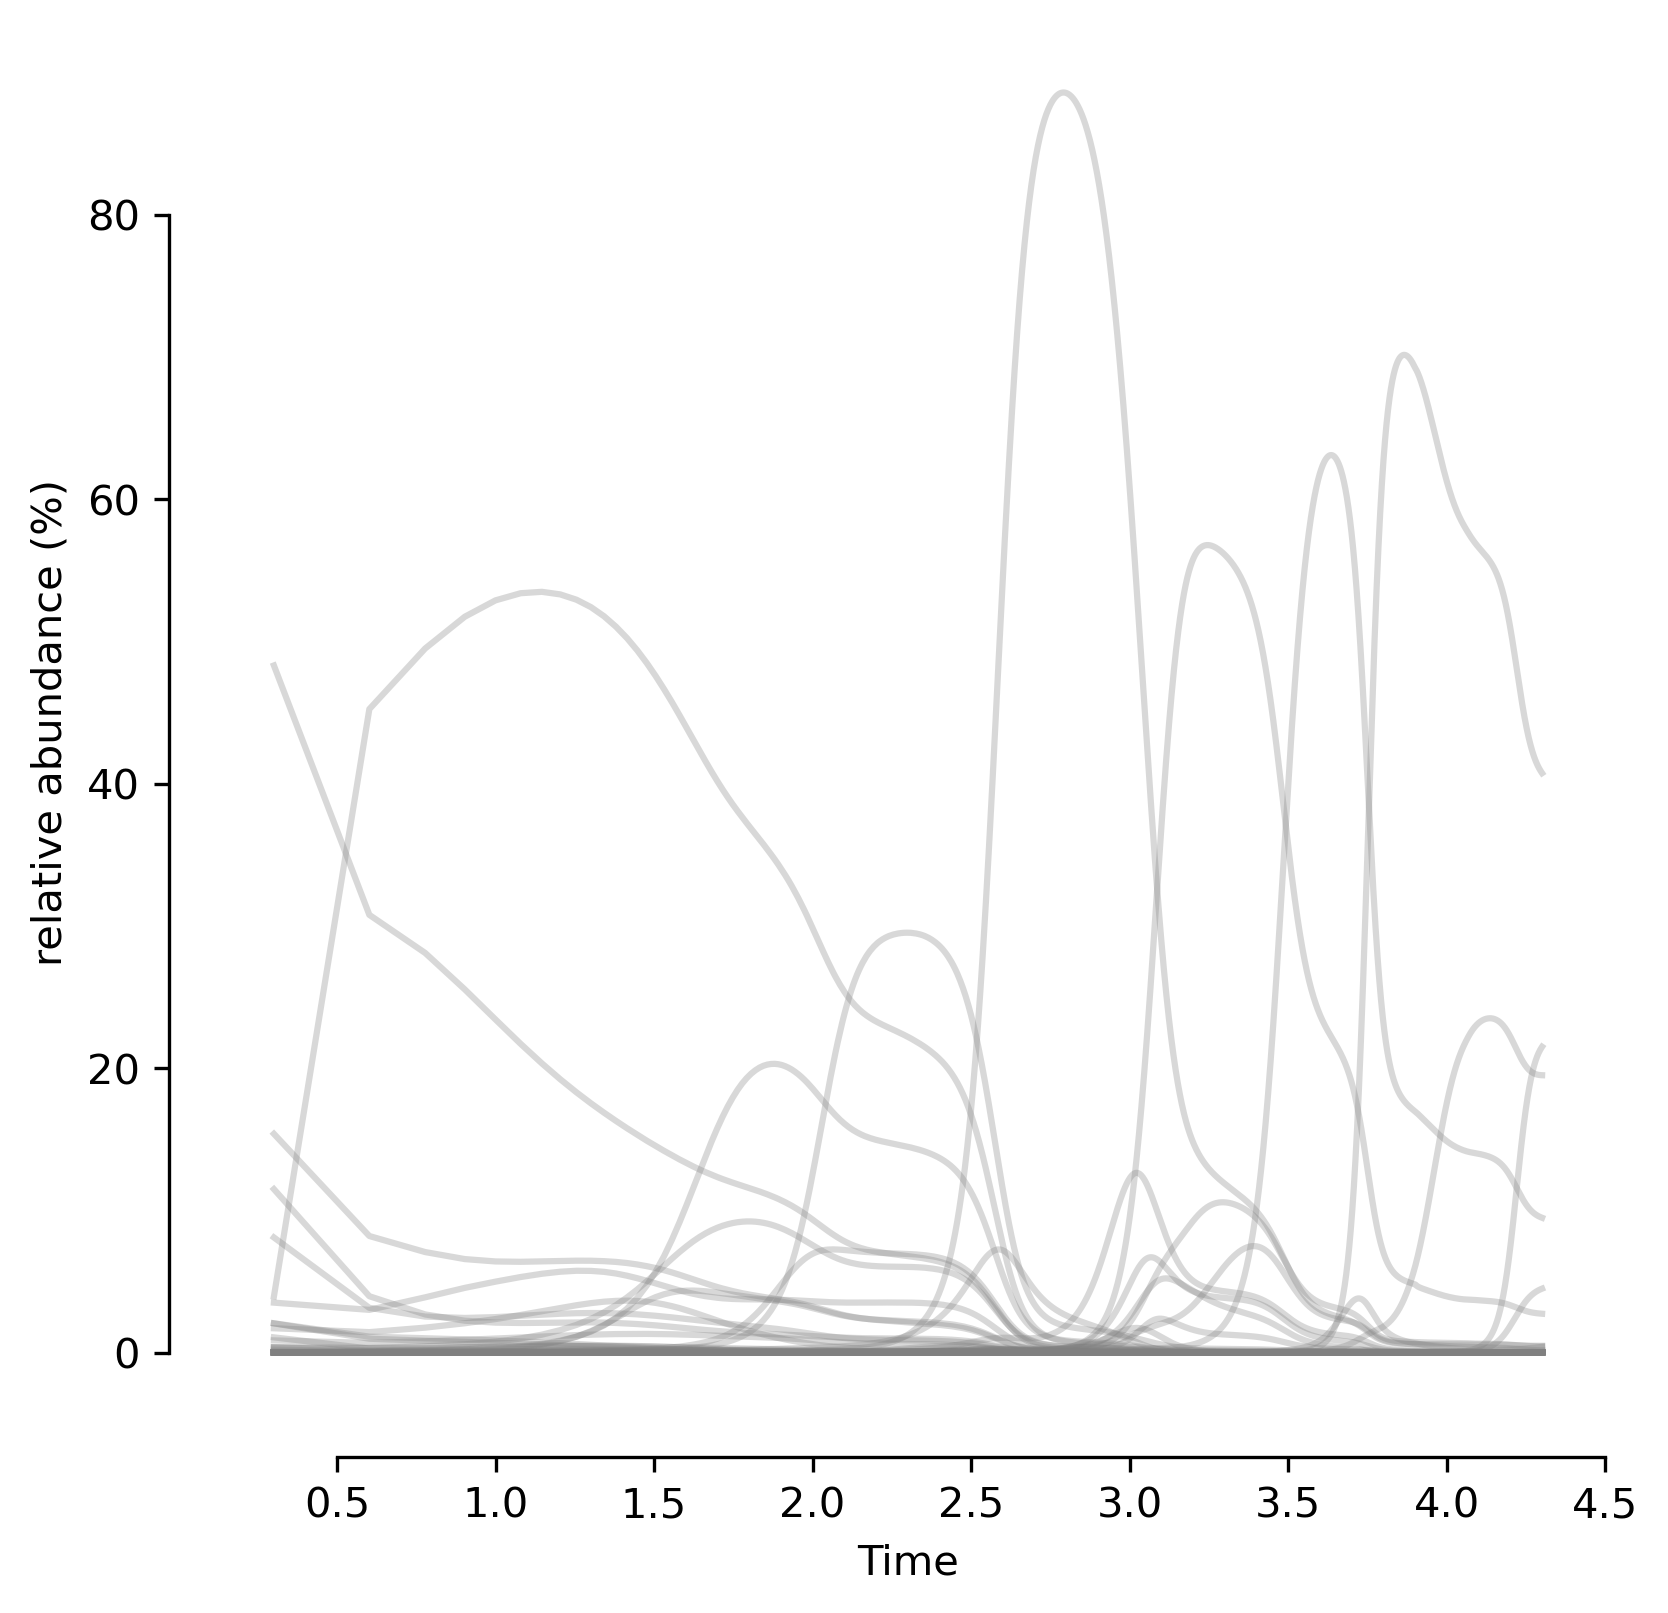

In [31]:
# plot species abudance trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.N):
    sns.lineplot(x=np.log10(repr_t), y=relative_abundance(repr_Ct)[i, :]*100,color='grey', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('relative abundance (%)')
sns.despine(offset=10, trim=True)

In [21]:
repr_Ct.shape

(50, 5000)

In [22]:
logmass = np.log10(avgm)

In [23]:
data_final= []
data_initial = []
for i in range(len(repr_Ct[:, 1])):
    freqf = round(repr_Ct[i, -1], None)
    freqi = round(repr_Ct[i, 0], None)
    data_final.append([logmass[i]]*freqf)
    data_initial.append([logmass[i]*freqi])

from functools import reduce
data_final = reduce(lambda x,y: x+y, data_final)
data_initial = reduce(lambda x,y: x+y, data_initial)


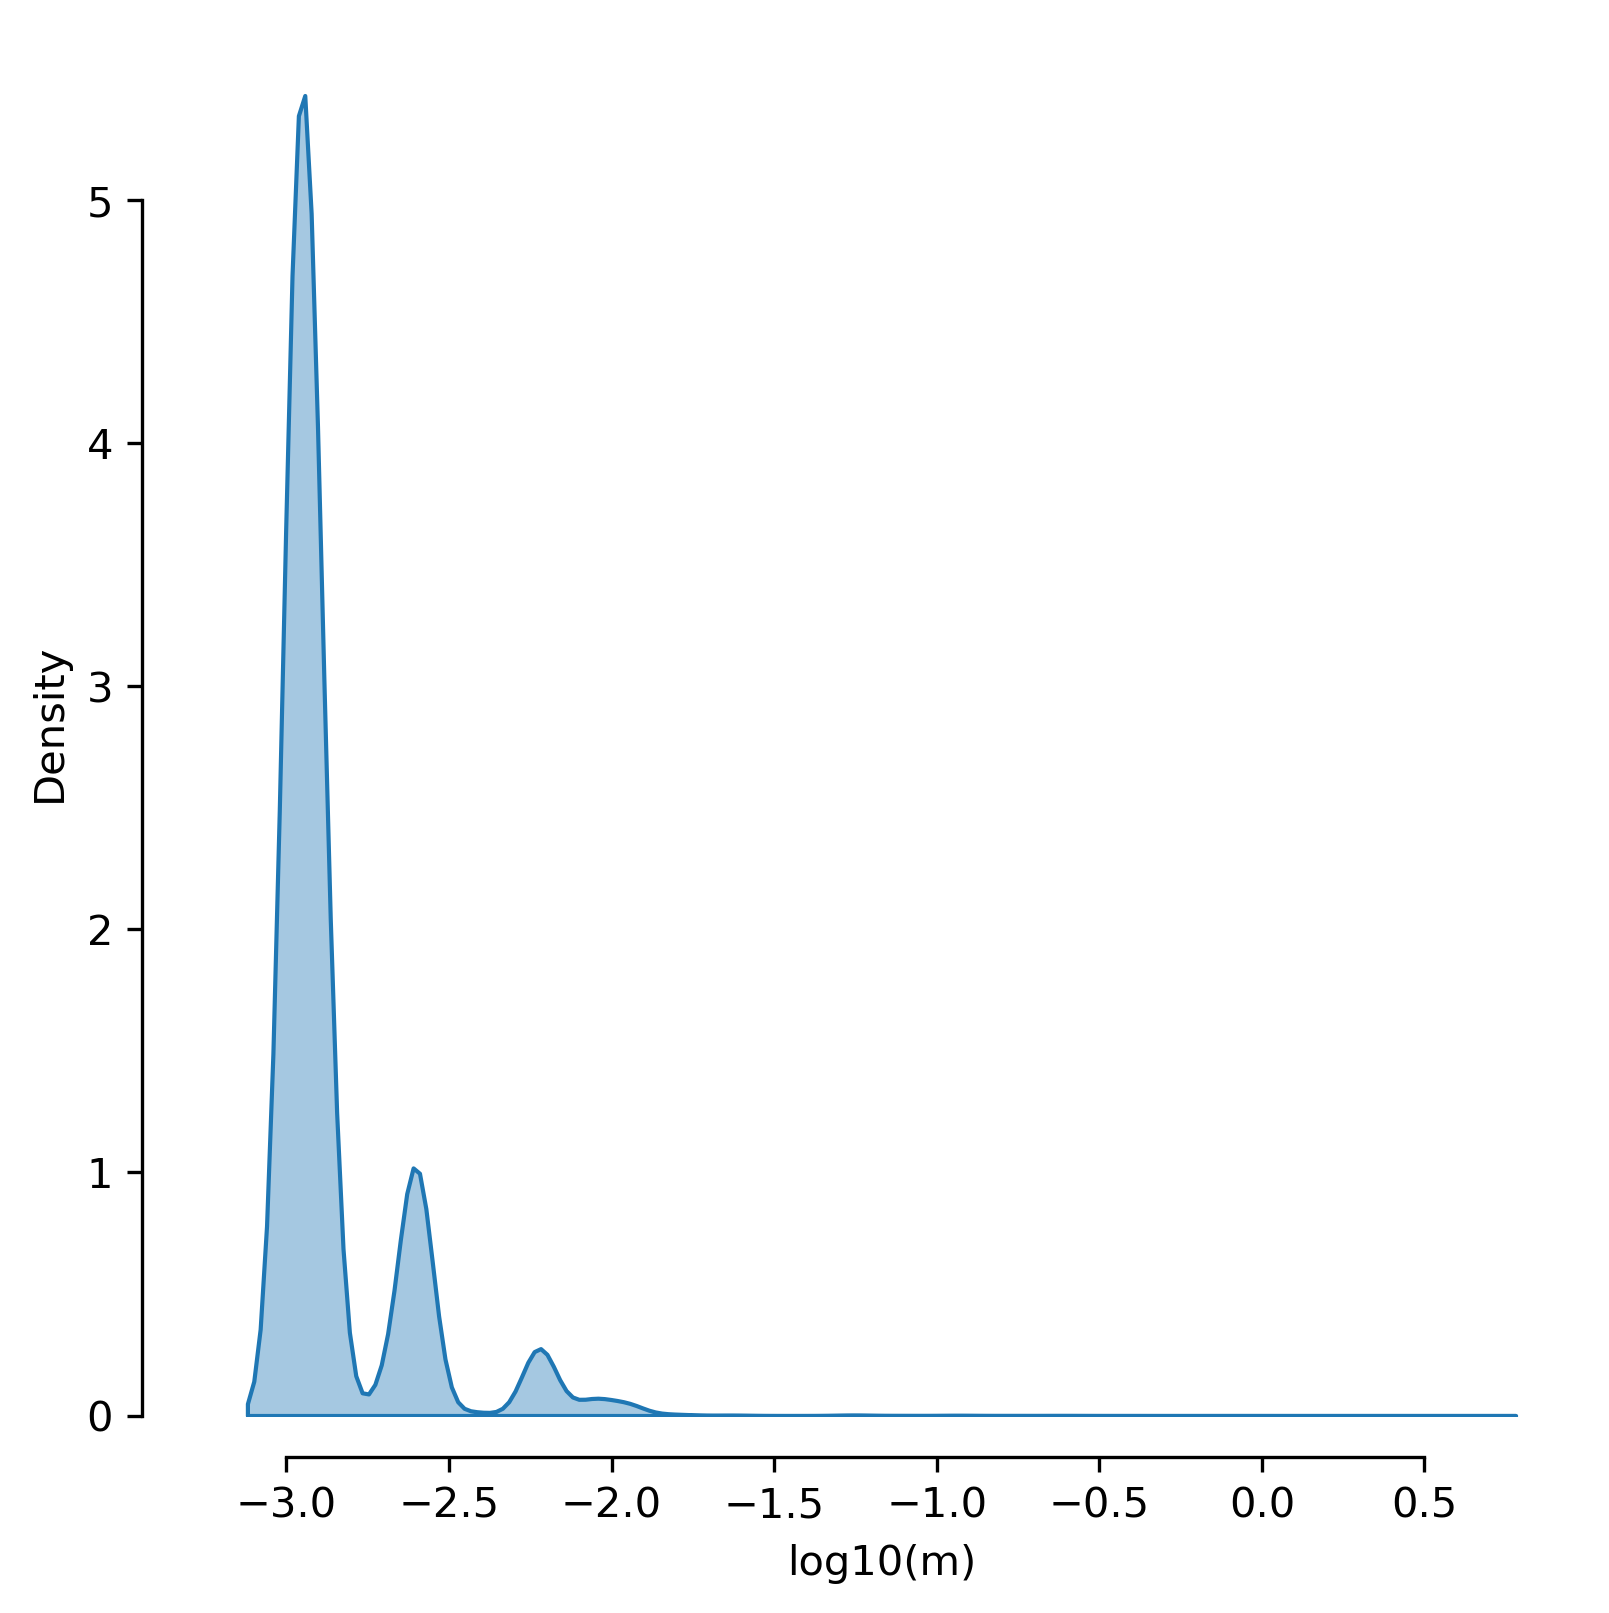

In [25]:
plt.figure(figsize=(6, 6), dpi=300)
sns.kdeplot(data_final, fill='red', alpha=0.4, bw_adjust=10)
# sns.kdeplot(data_initial, fill='grey', alpha=0.4)
# plt.legend()
plt.xlabel('log10(m)')
plt.xticks(rotation=45)
sns.despine(offset=10, trim=True)

## with ealry termination

In [61]:
base_dir = '..\Data'
sample_number = 1
type = '\eqAsb'
t_type = '_t.npy'
Para_type ='_Para.pkl'
Rt_type = '_Rt.npy'
Ct_type = '_Ct.npy'
id_type = 'speciesID.npy'
file_name = f'\eqAbl_{sample_number}'

In [62]:
# start loading
repr_t = np.load(base_dir + type + file_name + file_name + t_type)
repr_Rt = np.load(base_dir + type + file_name + file_name + Rt_type)
repr_Ct = np.load(base_dir + type + file_name + file_name + Ct_type)
para = pkl.load(open(base_dir + type + file_name + file_name + Para_type, 'rb'))
# idx = np.load(base_dir + type + file_name + file_name + id_type)

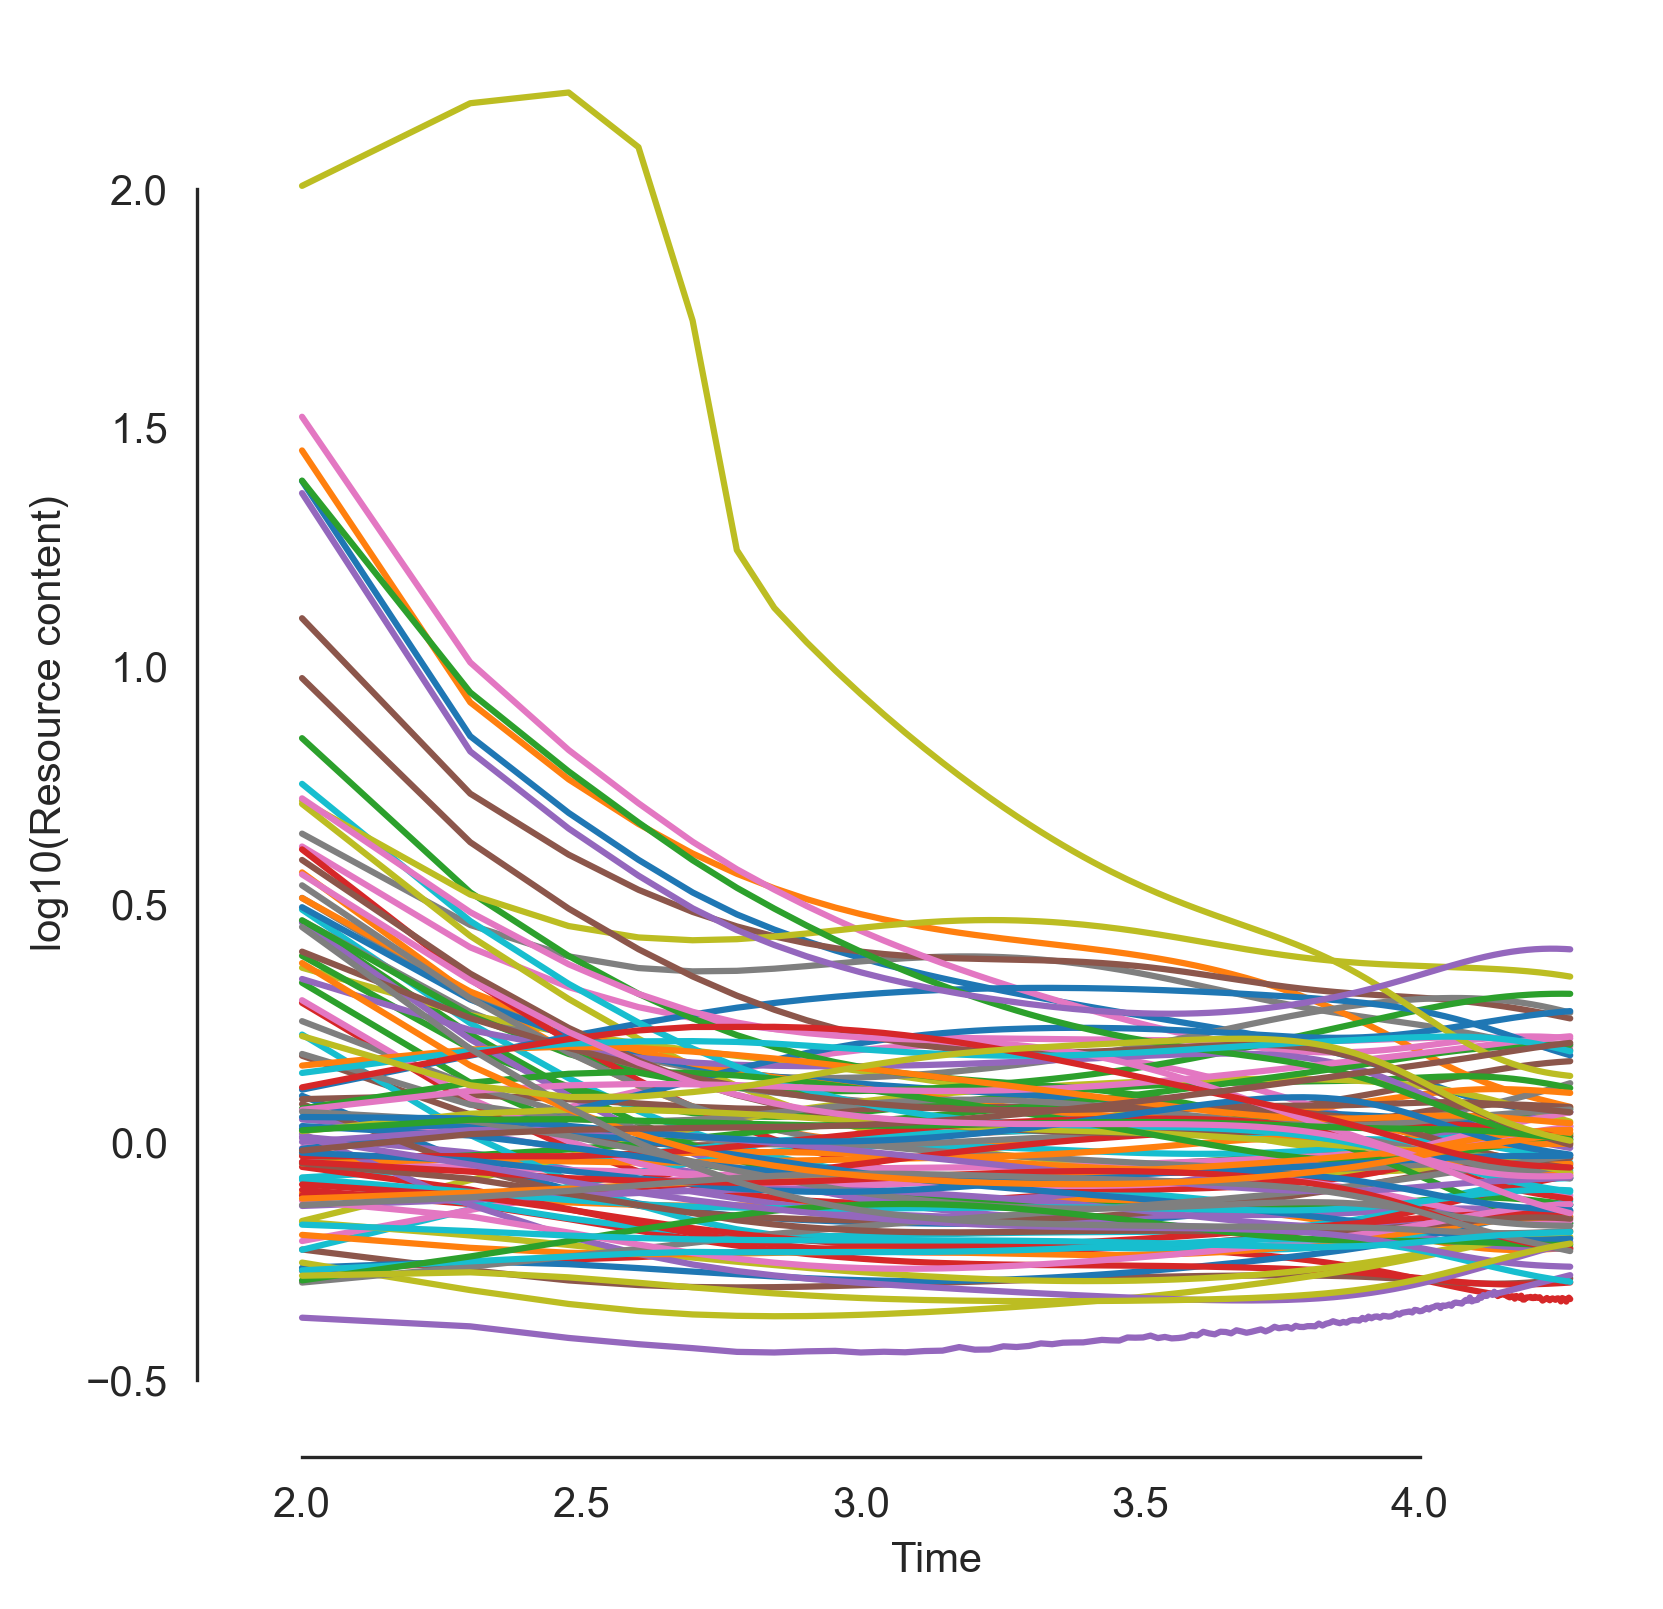

In [63]:
# plot species biomass trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.M):
    sns.lineplot(x=np.log10(repr_t), y=np.log10(repr_Rt[i, :]))
plt.xlabel('Time')
plt.ylabel('log10(Resource content)')
sns.despine(offset=10, trim=True)

Number of Species is 50
Number of resource is 100


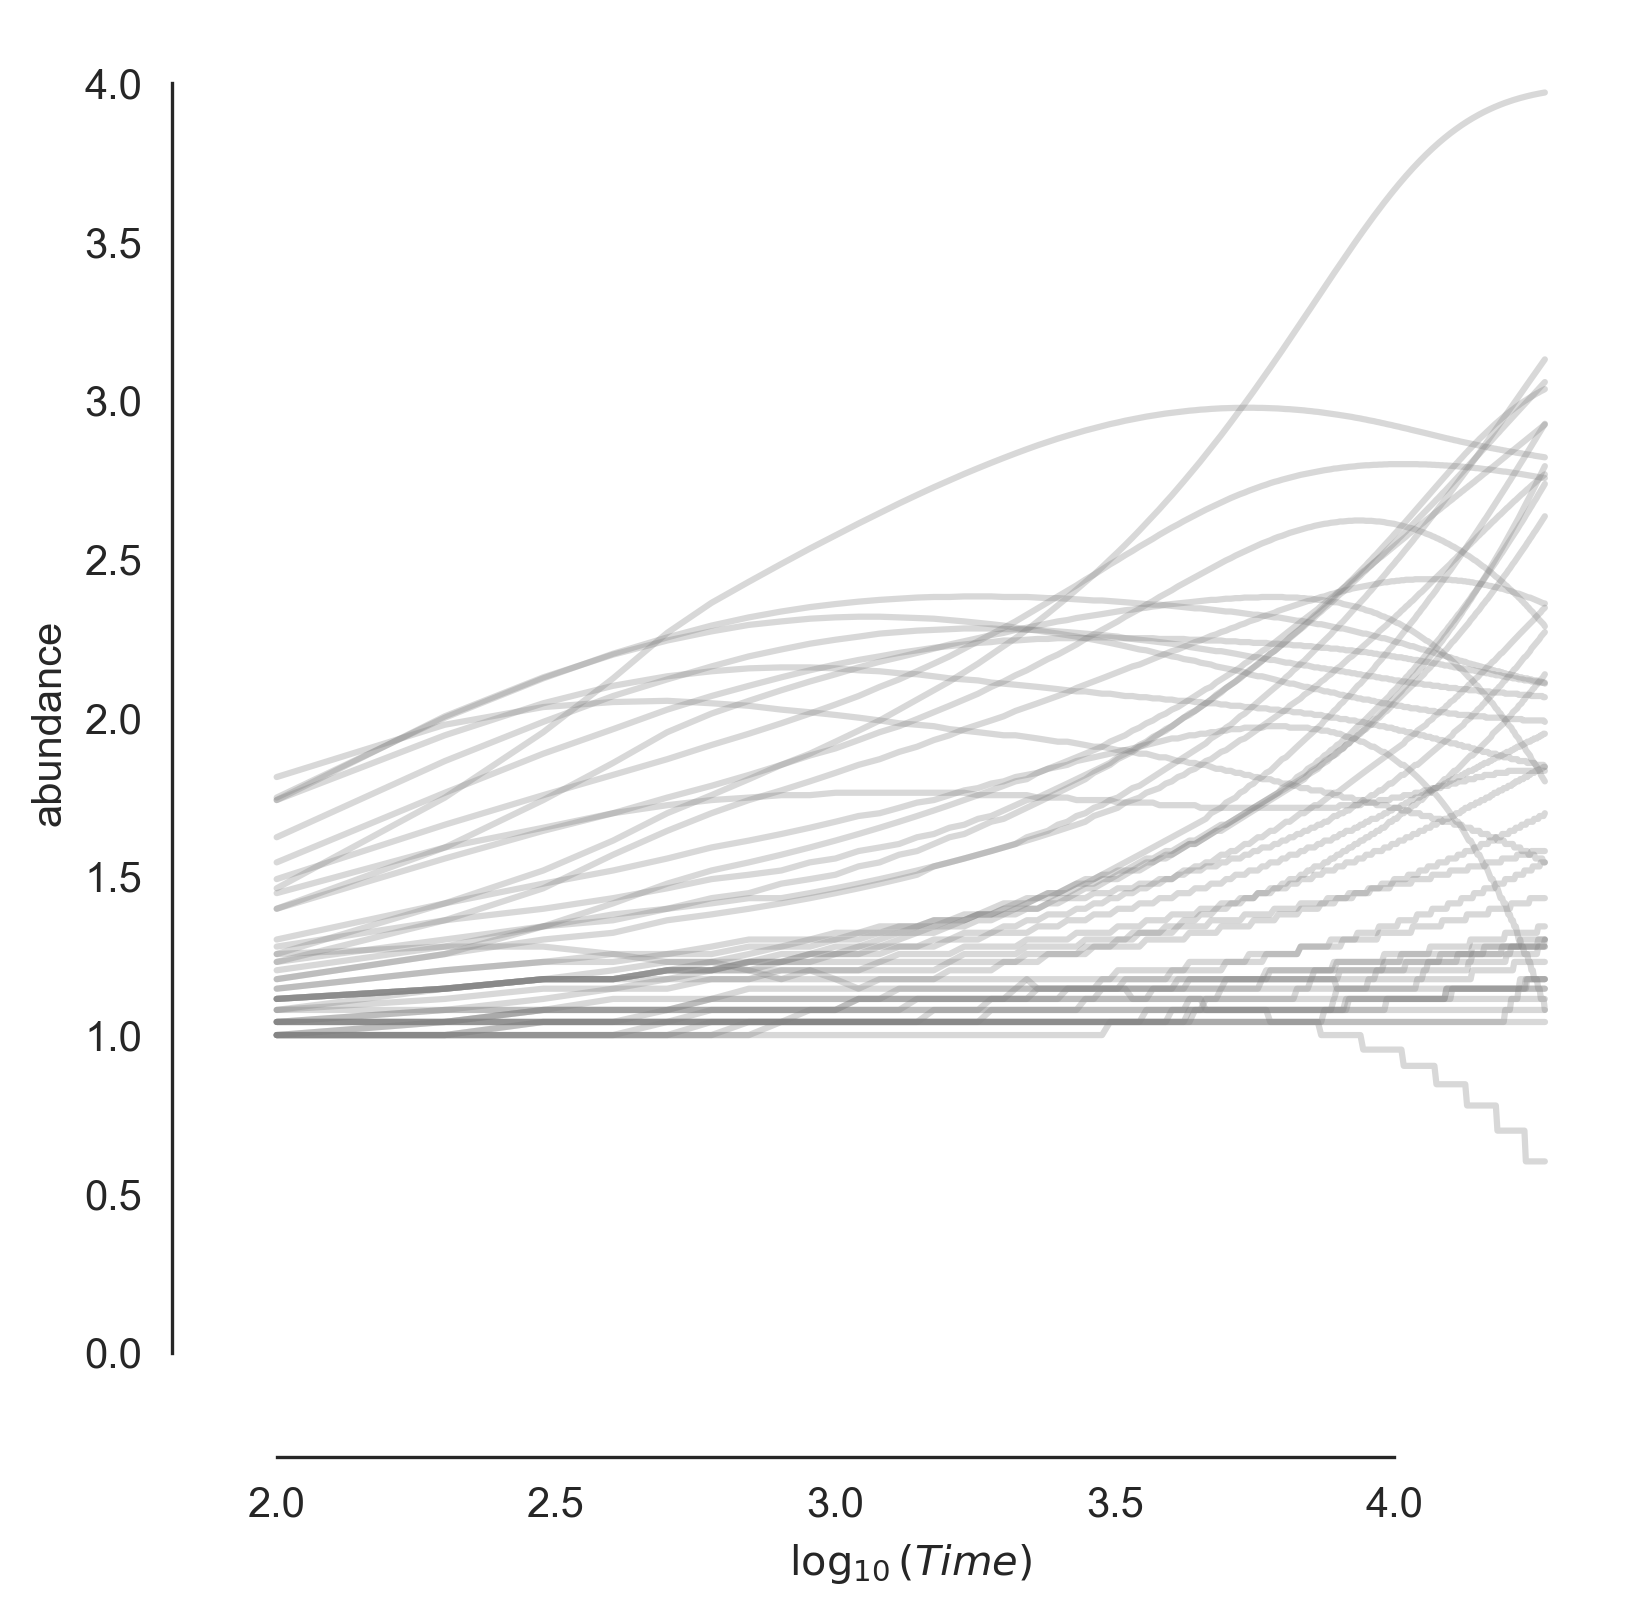

In [64]:
# get average mass
avgm = para.avgm.reshape(para.avgm.shape[0])

# calulate abundance
for j in range(len(repr_Ct[1, :])):
    repr_Ct[:, j] = repr_Ct[:, j]/avgm

# if abundance smaller than 1 then the species extincts
for i in range(len(repr_Ct[:, 1])):
    temp = repr_Ct[i, :]
    temp[temp < 1] = 0
    repr_Ct[i, :] = np.rint(temp)

# plot species biomass trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.N):
    sns.lineplot(x=np.log10(repr_t), y=np.log10(repr_Ct[i, :]), color='grey', alpha=0.3)
plt.xlabel('$\log_{10} ({Time})$')
plt.ylabel('abundance')
sns.despine(offset=10, trim=True)
print(f'Number of Species is {para.N}')
print(f'Number of resource is {para.M}')

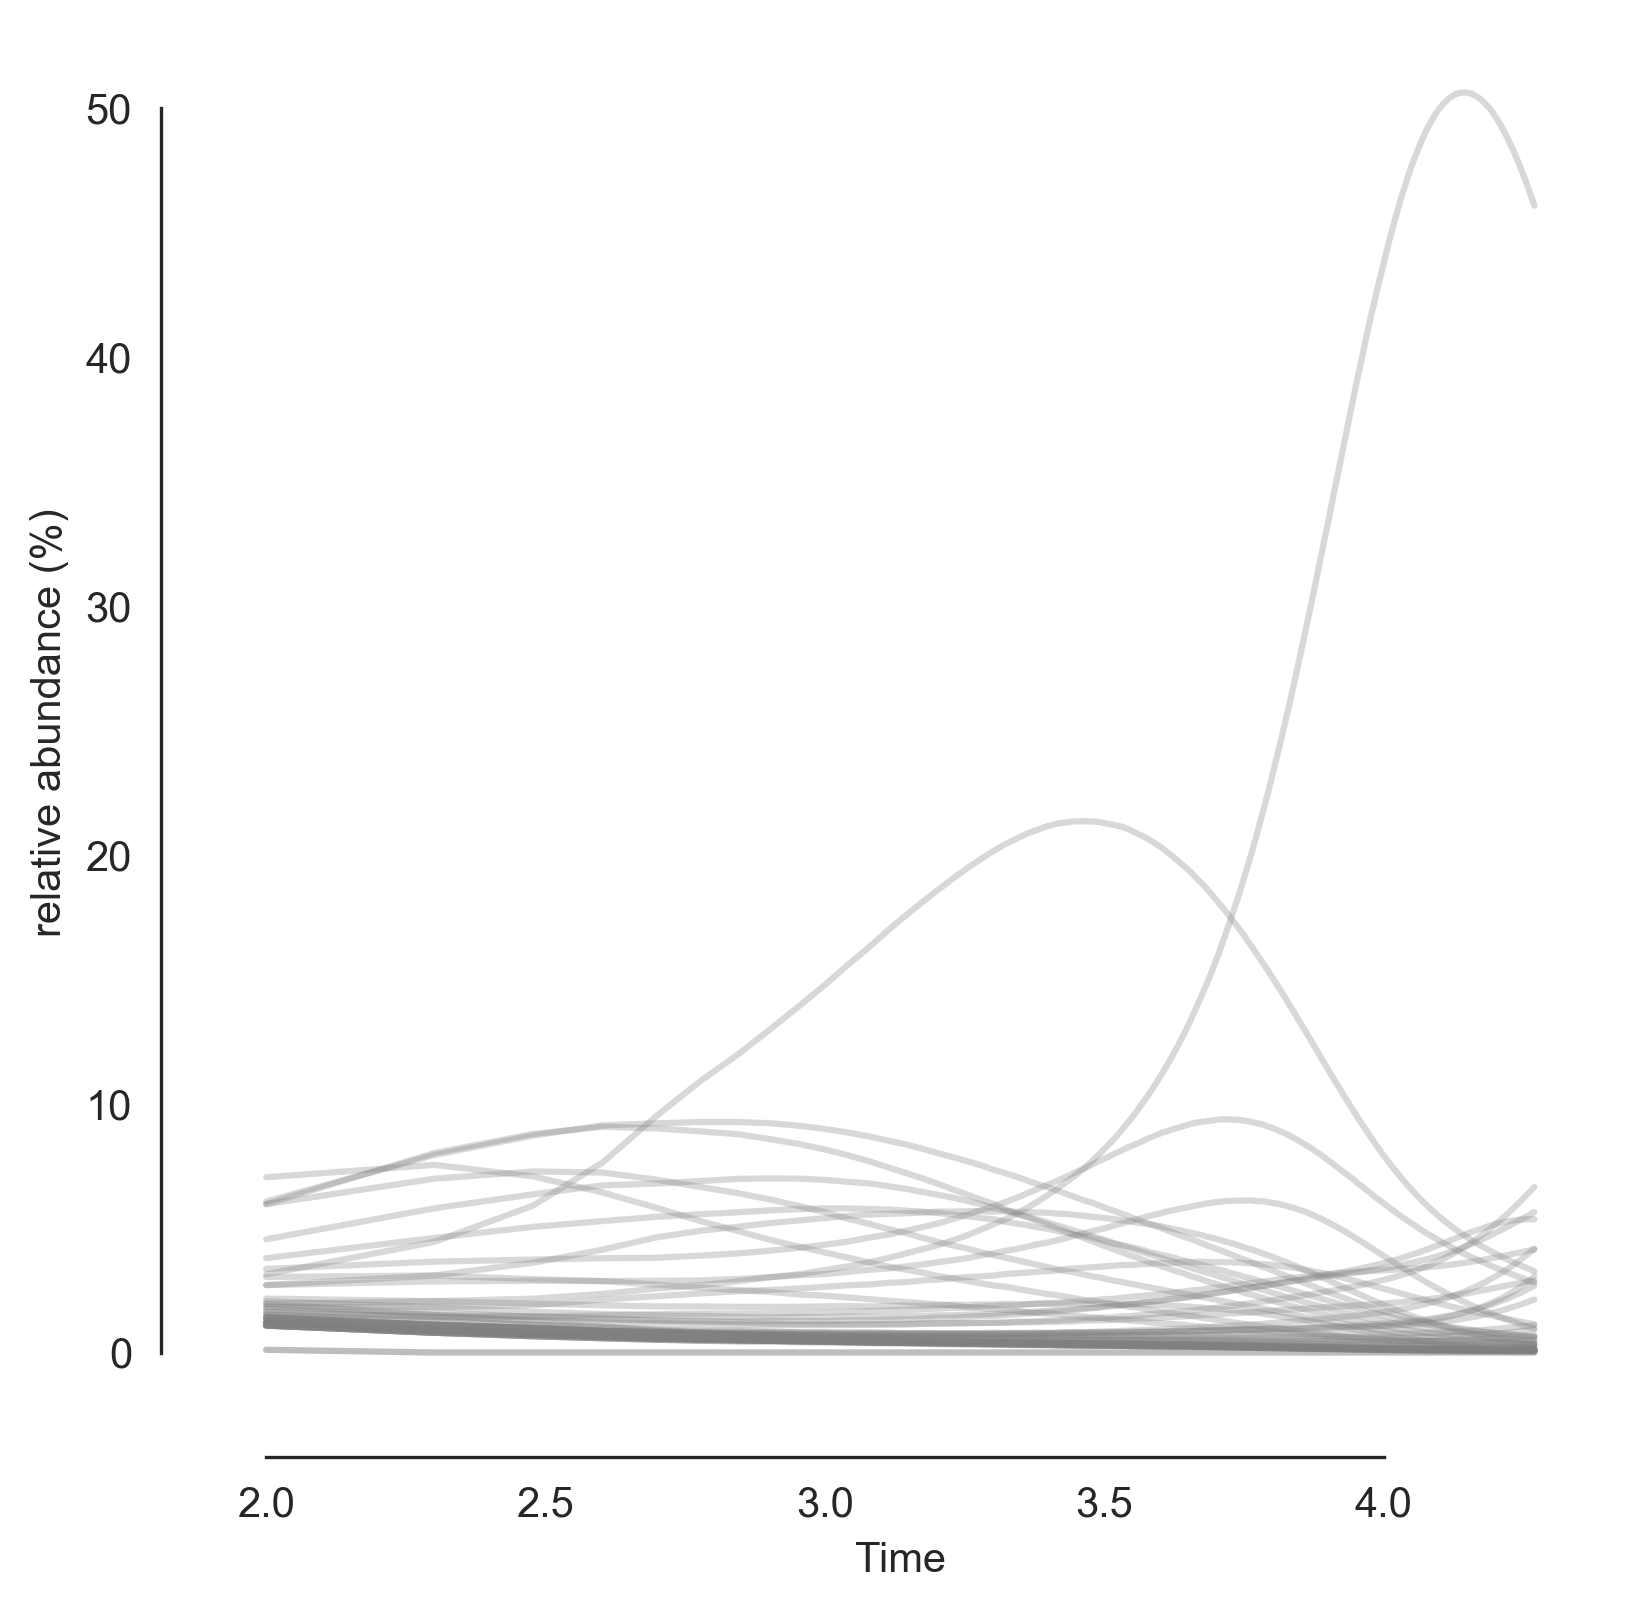

In [65]:
# plot species abudance trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.N):
    sns.lineplot(x=np.log10(repr_t), y=relative_abundance(repr_Ct)[i, :]*100,color='grey', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('relative abundance (%)')
sns.despine(offset=10, trim=True)

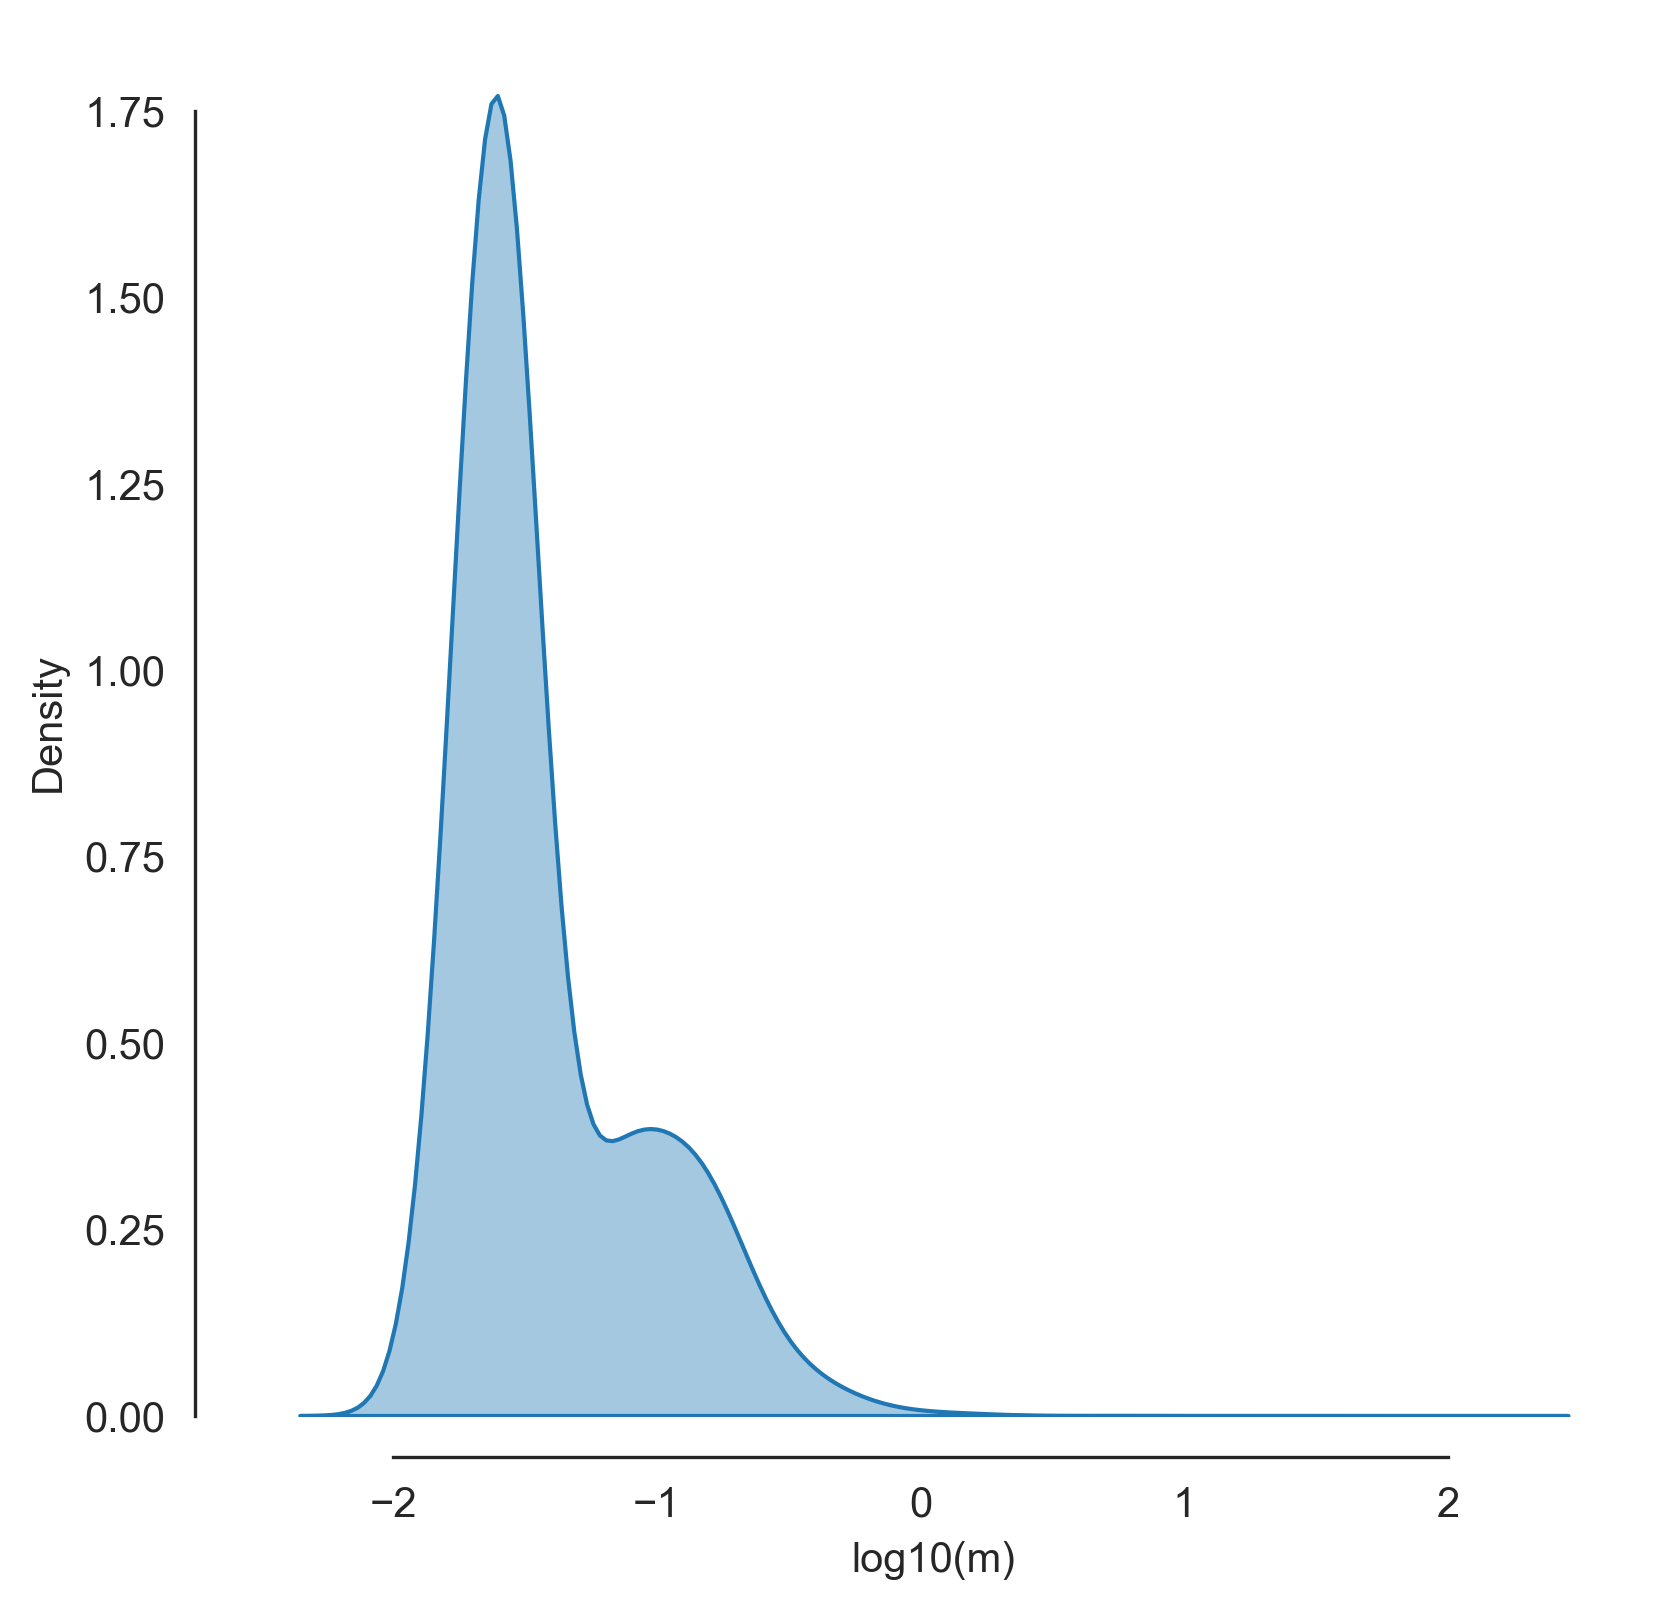

In [71]:
plt.figure(figsize=(6, 6), dpi=300)
sns.kdeplot(data_final, fill='red', alpha=0.4, bw_adjust=10)
# sns.kdeplot(data_initial, fill='grey', alpha=0.4)
# plt.legend()
plt.xlabel('log10(m)')
plt.xticks(rotation=45)
sns.despine(offset=10, trim=True)

# Species Sorting

In [148]:
print(repr_Ct.shape)
repr_Ct = (repr_Ct/np.sum(repr_Ct, 0))*100
repr_Ct[repr_Ct<1e-2] = 0

(50, 10000)


In [149]:
species_sorting = np.empty(repr_Ct.shape[1])
time = np.arange(repr_Ct.shape[1])
for i in range(repr_Ct.shape[1]):
    abdt = repr_Ct[:, i]
    num = len(abdt[abdt>0])
    species_sorting[i] = round(num)

In [150]:
species_sorting

array([24., 27., 25., ...,  7.,  7.,  7.])

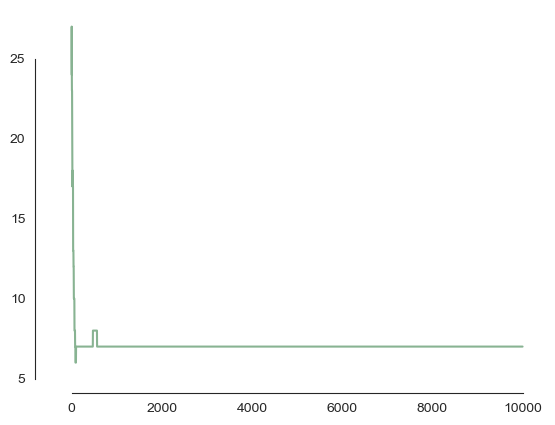

In [151]:
sns.set_style('white')
sns.lineplot(x=time, y=species_sorting, color='#88b392')
sns.despine(offset=10, trim=True)

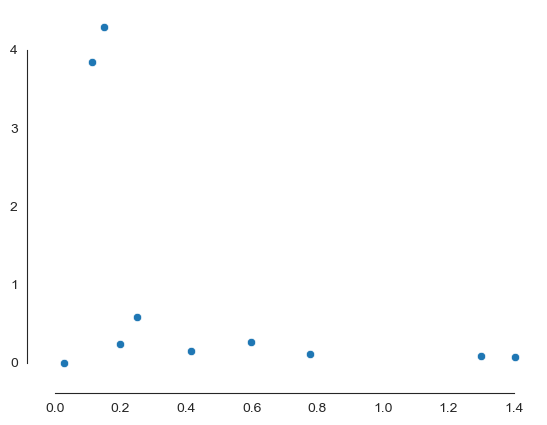

In [34]:
idx = np.where(repr_Ct[:, -1] > 0)[0]
oa = repr_Ct[idx, -1]
avgm_n = avgm[idx]
oa[oa>70] = 0
sns.set_style('white')
sns.scatterplot(x= avgm_n, y=oa)
sns.despine(offset=10, trim=True)


# Investigating the stability of Equilibrium state

### loading the data

In [51]:
base_dir = '..\Data'
sample_number = 1
type = '\eqAsb'
t_type = '_t.npy'
Para_type ='_Para.pkl'
Rt_type = '_Rt.npy'
Ct_type = '_Ct.npy'
id_type = '_ID.npy'
file_name = f'\eqAbl_{sample_number}'
t_asb = []
c_asb = []
r_asb = []
para_asb = []
id_asb = []

In [52]:
for i in range(1, 11):
    file_name = f'\eqAbl_{i}'
# start loading
    repr_t = np.load(base_dir + type + file_name + file_name + t_type)
    repr_Rt = np.load(base_dir + type + file_name + file_name + Rt_type)
    repr_Ct = np.load(base_dir + type + file_name + file_name + Ct_type)
    para = pkl.load(open(base_dir + type + file_name + file_name + Para_type, 'rb'))
    repr_id = np.load(base_dir + type + file_name + f'\Abl_{i}' + id_type)
    t_asb.append(repr_t)
    c_asb.append(repr_Ct)
    r_asb.append(repr_Rt)
    para_asb.append(para)
    id_asb.append(repr_id)

In [53]:
renum = 4
C = c_asb[renum]
t = t_asb[renum]
R = r_asb[renum]
para = para_asb[renum]
id = id_asb[renum]
ss_list = []


In [89]:
ss = np.concatenate([repr_Ct[:, -4].tolist(), repr_Rt[:, -4].tolist()])

In [90]:
def jacobian(ss, para:Paras):
    
    # values and paras for calculating jacobian
    N, M, l, p, D, avgm, type = para.N, para.M, para.l, para.p, para.D, para.avgm, para.type
    vmax = para.v_in_max
    Rss = ss[N:N+M].reshape(M, 1)
    Css = ss[0:N].reshape(N, 1)
    # print(Css)
    avgm = avgm.reshape(N, 1)
    print(vmax.shape)
    vmax = scale_vin(vmax, avgm, para.B0, para.alpha)
    v_in = vin(p, Rss, para.R_half, vmax, type)
    v_grow = vgrow(v_in, l)
    v_out = vout(v_in, l, D)
    # v_out = scale_vout(v_out, avgm, para.E0, para.gamma)
    nc = vmax*p*para.R_half

    # jacobian
    J = np.zeros((para.N+para.M, para.N+para.M))
    

    for n in range(para.N):
        # dfn/dCn
        J[n, n] = para.mu * (v_grow[n] - para.m[n])

        # dfn/dRm
        for m in range(para.M):
            J[n, m] = para.mu * Css[n] * (1-l[m]) * (nc[n, m]/(para.R_half + p[n, m]* Rss[m])**2)
    
    for m in range(para.M):
        # dfN+n/dRm
        J[N+m, m] = (D[m, m] - 1)*para.km*np.dot(Css.reshape(N, ), (nc[:, m]/((para.R_half + p[:, m]*Rss[m])**2)))

        for n in range(para.N):
            # dfN+n/dCn
            J[N+m, n] = para.km * Css[n]*(v_out[n, m]-v_in[n, m])
    
    eigval, eigvec = np.linalg.eig(J)
    # eigval = np.sort(np.real(eigval))

    return J, eigval, eigvec


In [91]:
J, eigval, eigvec = jacobian(ss, para)

(50, 100)


In [125]:
np.max(eigval)

(1.9004741775675322+3.251617304452781j)

## Eigenvalues for different values of w

In [123]:
warray = np.linspace(1, 2, 50)
ss_list = []
max_eigenval = []
for i, val in enumerate(warray):
    val = round(val, 2)
    dir = f'..\Data\\varyw\w_{val}'
    C = np.load(dir +'\\vw_Ct.npy')[:, -1].tolist()
    R = np.load(dir +'\\vw_Rt.npy')[:, -1].tolist()
    para = pkl.load(open(dir+'\\vw_para.pkl', 'rb'))
    ss = np.concatenate([C, R])
    ss_list.append(ss)
    J, eigval, eigvec = jacobian(ss, para)
    max_eigenval.append(np.max(np.real(eigval)))

(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)


Text(0, 0.5, 'maximum $Re(\\lambda)$')

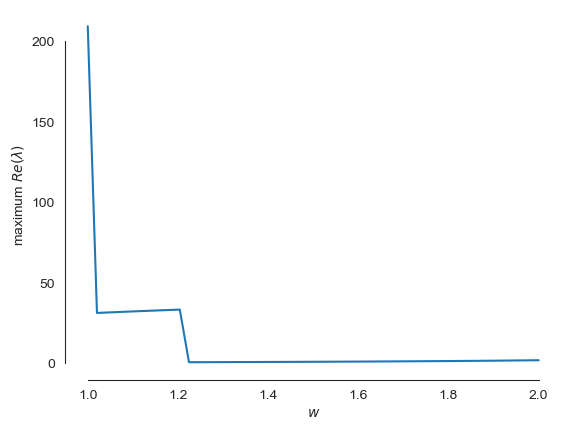

In [124]:
sns.lineplot(x=warray, y=max_eigenval)
sns.despine(trim=True, offset=0.5)
plt.xlabel('$w$')
plt.ylabel('maximum $Re(\lambda)$')

# Creating intereaction network

In [126]:
para = pkl.load(open('..\Data\\variedC\w_1\w1_sAbl_1_Para.pkl', 'rb'))

In [127]:
def graph_dictL(para:Paras):

    N, M, P, D = para.N, para.M, para.p, para.D

    
    A = {}

    for n in range(1, N+1):
        
        id = np.where(D[n-1, :]>0)[0]
        A[f'C{n}'] = [f'R{m+1}' for m in id]

    for m in range(1, M+1):
        id = np.where(P[:, m-1]>0)[0]
        A[f'R{m}'] = [f'C{n+1}' for n in id]
    
    dG = nx.DiGraph(A)
    G = nx.Graph(A)
    return A, dG, G


In [128]:
D, dG, G = graph_dictL(para)


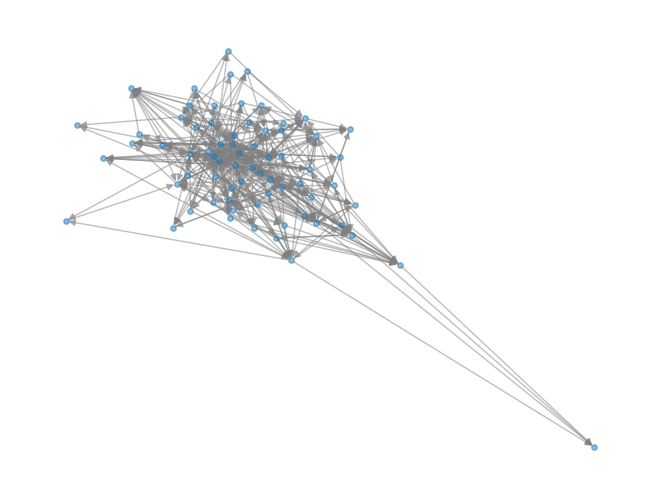

In [129]:
pos = nx.spring_layout(dG, seed=1448)
nx.draw(dG, pos=pos, node_size=15, edge_color='grey', alpha=0.5)

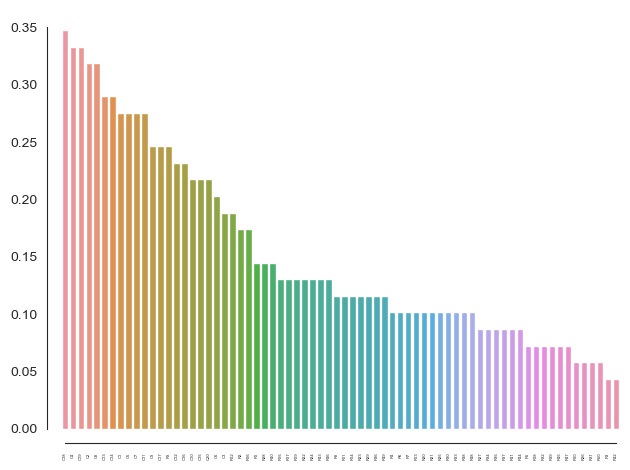

In [118]:
a = nx.degree_centrality(dG)
a = dict(sorted(a.items(), key=lambda a:a[1], reverse=True))
sns.barplot(x = list(a.keys()), y=list(a.values()))
sns.despine(trim=True, offset=10)
plt.xticks(rotation=90, fontsize=3)
plt.tight_layout()

In [119]:
d = list(a.items())
val = 1.
info = ''
for i in range(len(d)):
    if 'C' in d[i][0]:
        if d[i][1] < val:
            val = d[i][1]
            info = d[i][0]

In [120]:
bc = nx.betweenness_centrality(dG)
bc = dict(sorted(bc.items(), key=lambda bc:bc[1], reverse=True))

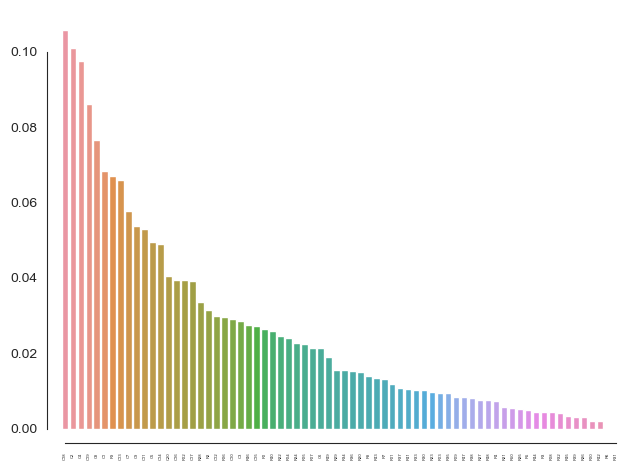

In [121]:
sns.barplot(x = list(bc.keys()), y=list(bc.values()))
sns.despine(trim=True, offset=10)
plt.xticks(rotation=90, fontsize=3)
plt.tight_layout()

In [ ]:
iGidl = list(dG.in_degree)
Gid = {iGidl[i][0]:iGidl[i][1] for i in range(len(iGidl))}
Gid = dict(sorted(Gid.items(), key=lambda Gid:Gid[1], reverse=True))
x = list(Gid.keys())
y = list(Gid.values())

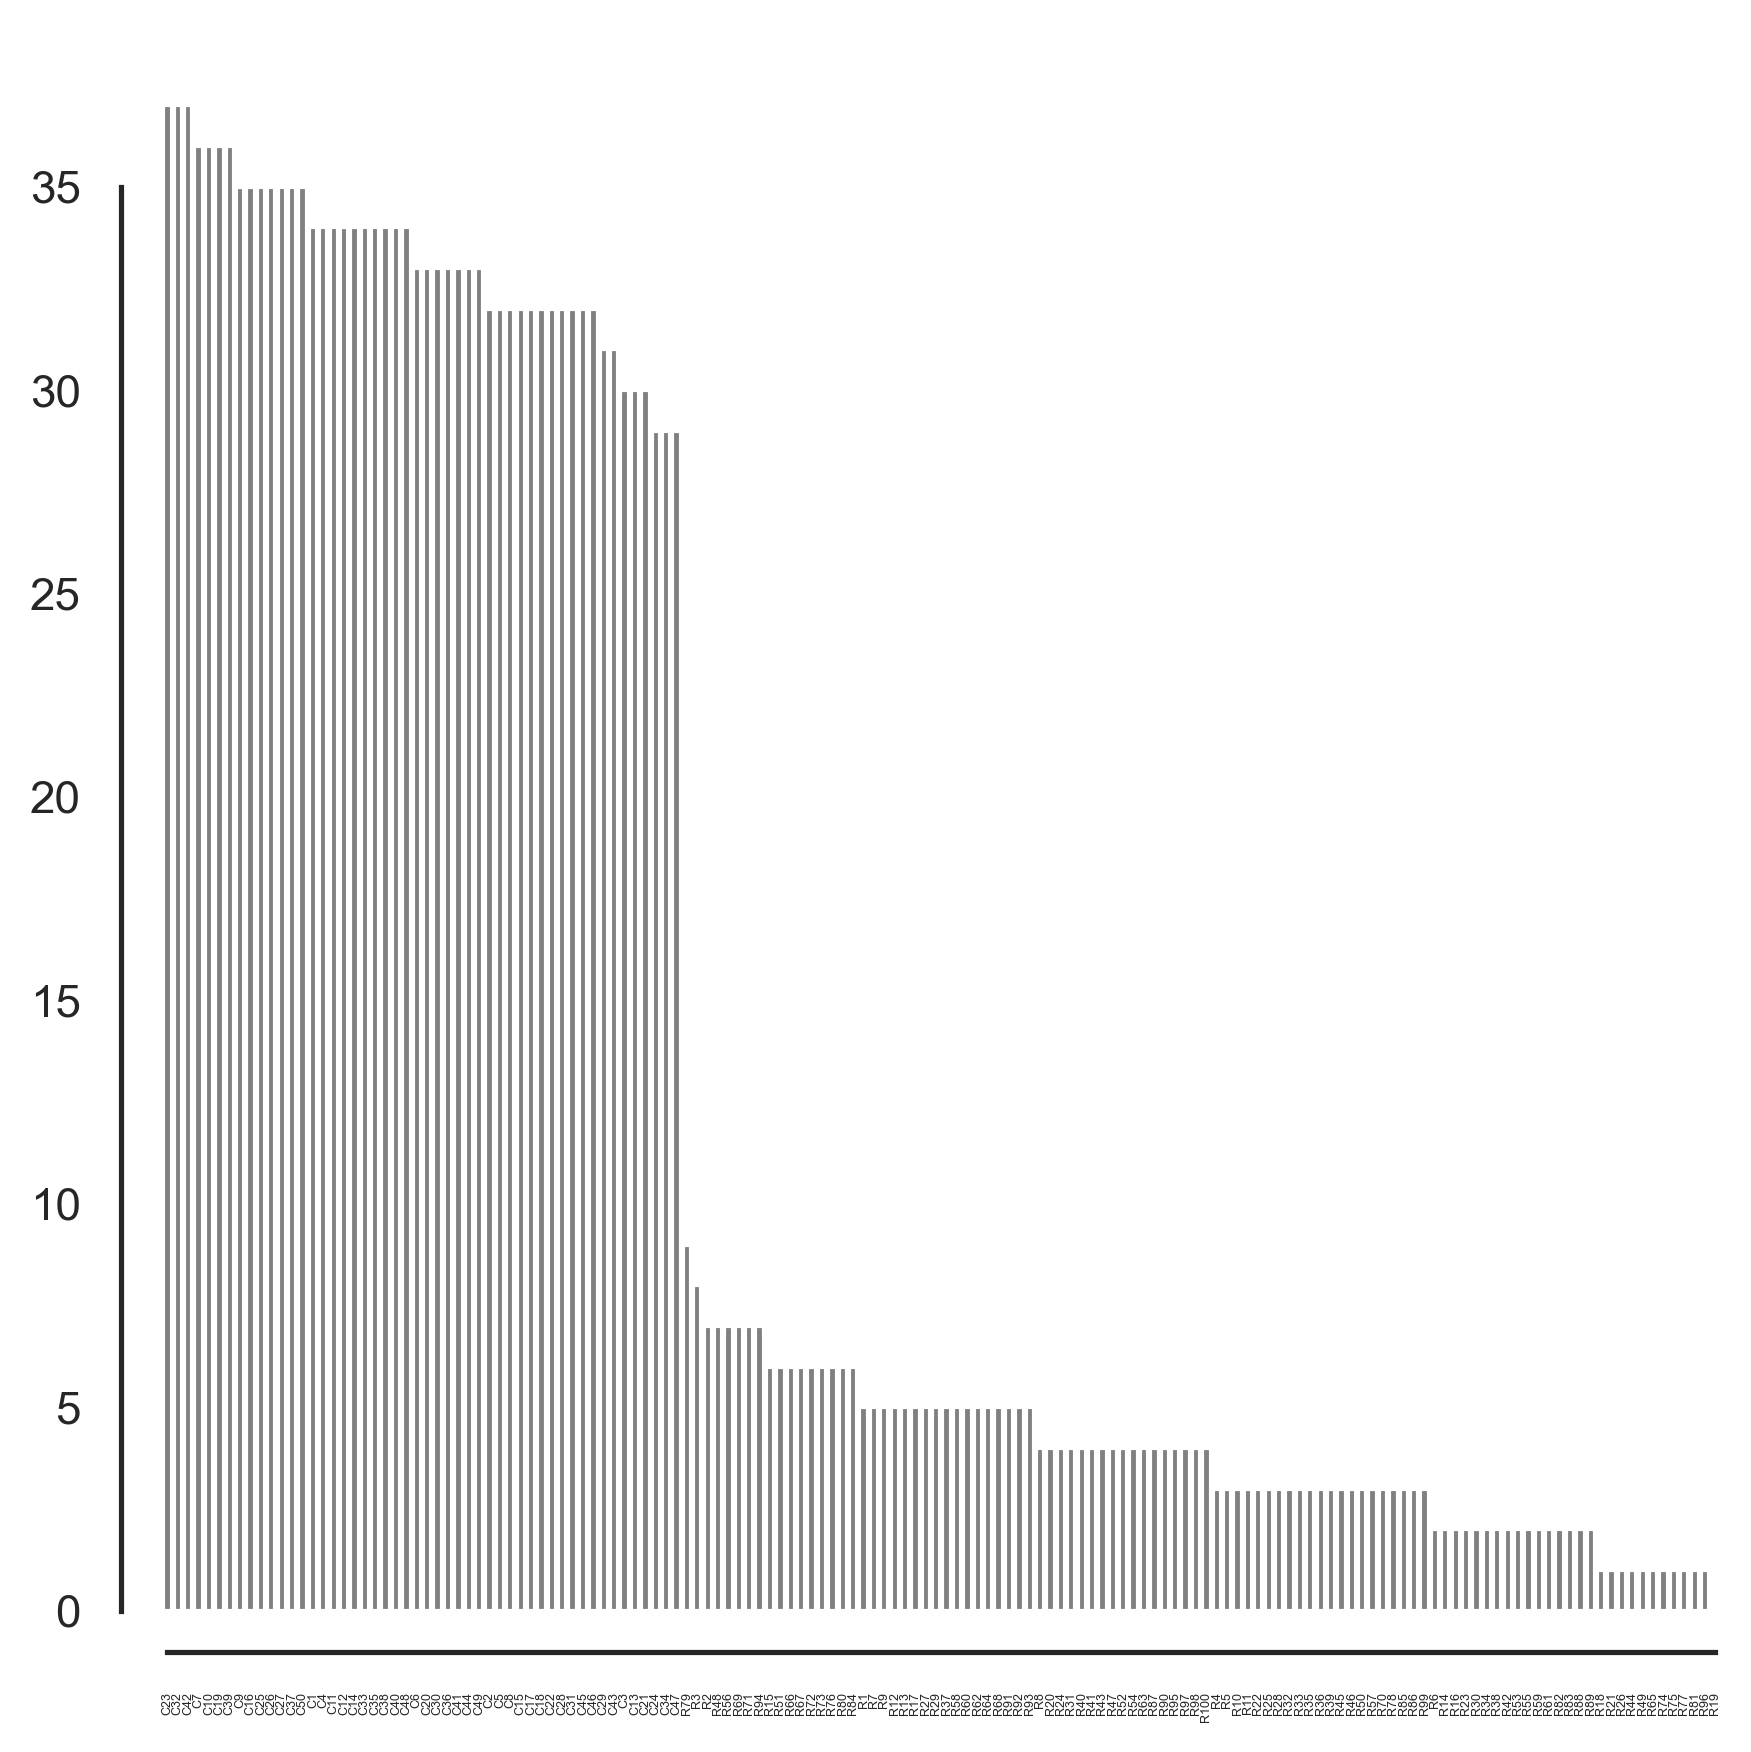

In [ ]:
sns.barplot(x = x, y=y, color='grey')
sns.despine(trim=True, offset=10)
plt.xticks(rotation=90, fontsize=3)
plt.tight_layout()

In [ ]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

# Scaling -- Analysis

## Loading data

In [3]:
alphas = []
betas = []
for i in range(10):
    dir = f'F:\Study\FYP\CellSizeBCAu\Data\\alphas\pair_{i+1}'
    alphas.append(load_data(dir, 10, 'all'))
    dir = f'F:\Study\FYP\CellSizeBCAu\Data\\betas\pair_{i+1}'
    betas.append(load_data(dir, 10, 'all'))

In [4]:
def species_sorting(data, para:Paras):
    
    spn, t = data.shape
    avgm = para.avgm.reshape(spn,)
    feasibility = np.empty(t)

    for i in range(t):
        data[:, i] = data[:, i]/avgm
        feasibility[i] = data[data[:, i]>0.6, i].shape[0]
    return feasibility

In [5]:
def convert_dataframe_condition(conditioned_data):

    df_list = []
    for i in range(10):
        data = conditioned_data[i]
        _, t = data['Ct'].shape
        temp_dic = {k:data[k] for k in ('t', 'scaling exponents')}
        temp_dic['t'] = temp_dic['t'][0:int(0.8*t)]
        temp_dic['scaling exponents'] = [np.round(temp_dic['scaling exponents'], 2)]*t
        temp_dic['scaling exponents'] = temp_dic['scaling exponents'][0:int(0.8*t)]
        if 'sample number' in temp_dic.keys():
            temp_dic['sample number'].append([f'sample {i+1}' for _ in range(int(0.8*t))]) 
        else:
            temp_dic['sample number'] = [f'sample {i+1}' for _ in range(int(0.8*t))]
        temp_dic['sample number'] = np.array(temp_dic['sample number']).flatten()
        feasibility = species_sorting(data['Ct'], data['para'])[0:int(0.8*t)]
        temp_dic['Coexsistence'] = feasibility
        df_list.append(pd.DataFrame.from_dict(temp_dic))

    return pd.concat(df_list)


In [6]:
dfs = []
for j in range(len(alphas)):
    sample_df = convert_dataframe_condition(alphas[j])
    dfs.append(sample_df)
all_pair_df_alphas = pd.concat(dfs)
dfs = []
for j in range(len(betas)):
    sample_df = convert_dataframe_condition(betas[j])
    dfs.append(sample_df)
all_pair_df_betas = pd.concat(dfs)

In [7]:
all_pair_df_alphas

,t,scaling exponents,sample number,Coexsistence
0,0.00000,"[0.5, 0.72]",sample 1,50.0
1,3.00030,"[0.5, 0.72]",sample 1,46.0
2,6.00060,"[0.5, 0.72]",sample 1,47.0
3,9.00090,"[0.5, 0.72]",sample 1,46.0
4,12.00120,"[0.5, 0.72]",sample 1,46.0
...,...,...,...,...
7995,23987.39874,"[1.0, 0.72]",sample 10,15.0
7996,23990.39904,"[1.0, 0.72]",sample 10,15.0
7997,23993.39934,"[1.0, 0.72]",sample 10,15.0
7998,23996.39964,"[1.0, 0.72]",sample 10,15.0


## Analysing the effects of cell size scaling

- This is the analysis of the effects of $\alpha$, which is the scaling exponents for the **$V_{max}$**

C:\Users\IVANN\AppData\Local\Temp\ipykernel_18560\2011168490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finaldf['scaling exponents'] = [finaldf['scaling exponents'].iloc[i][0] for i in range(100)]


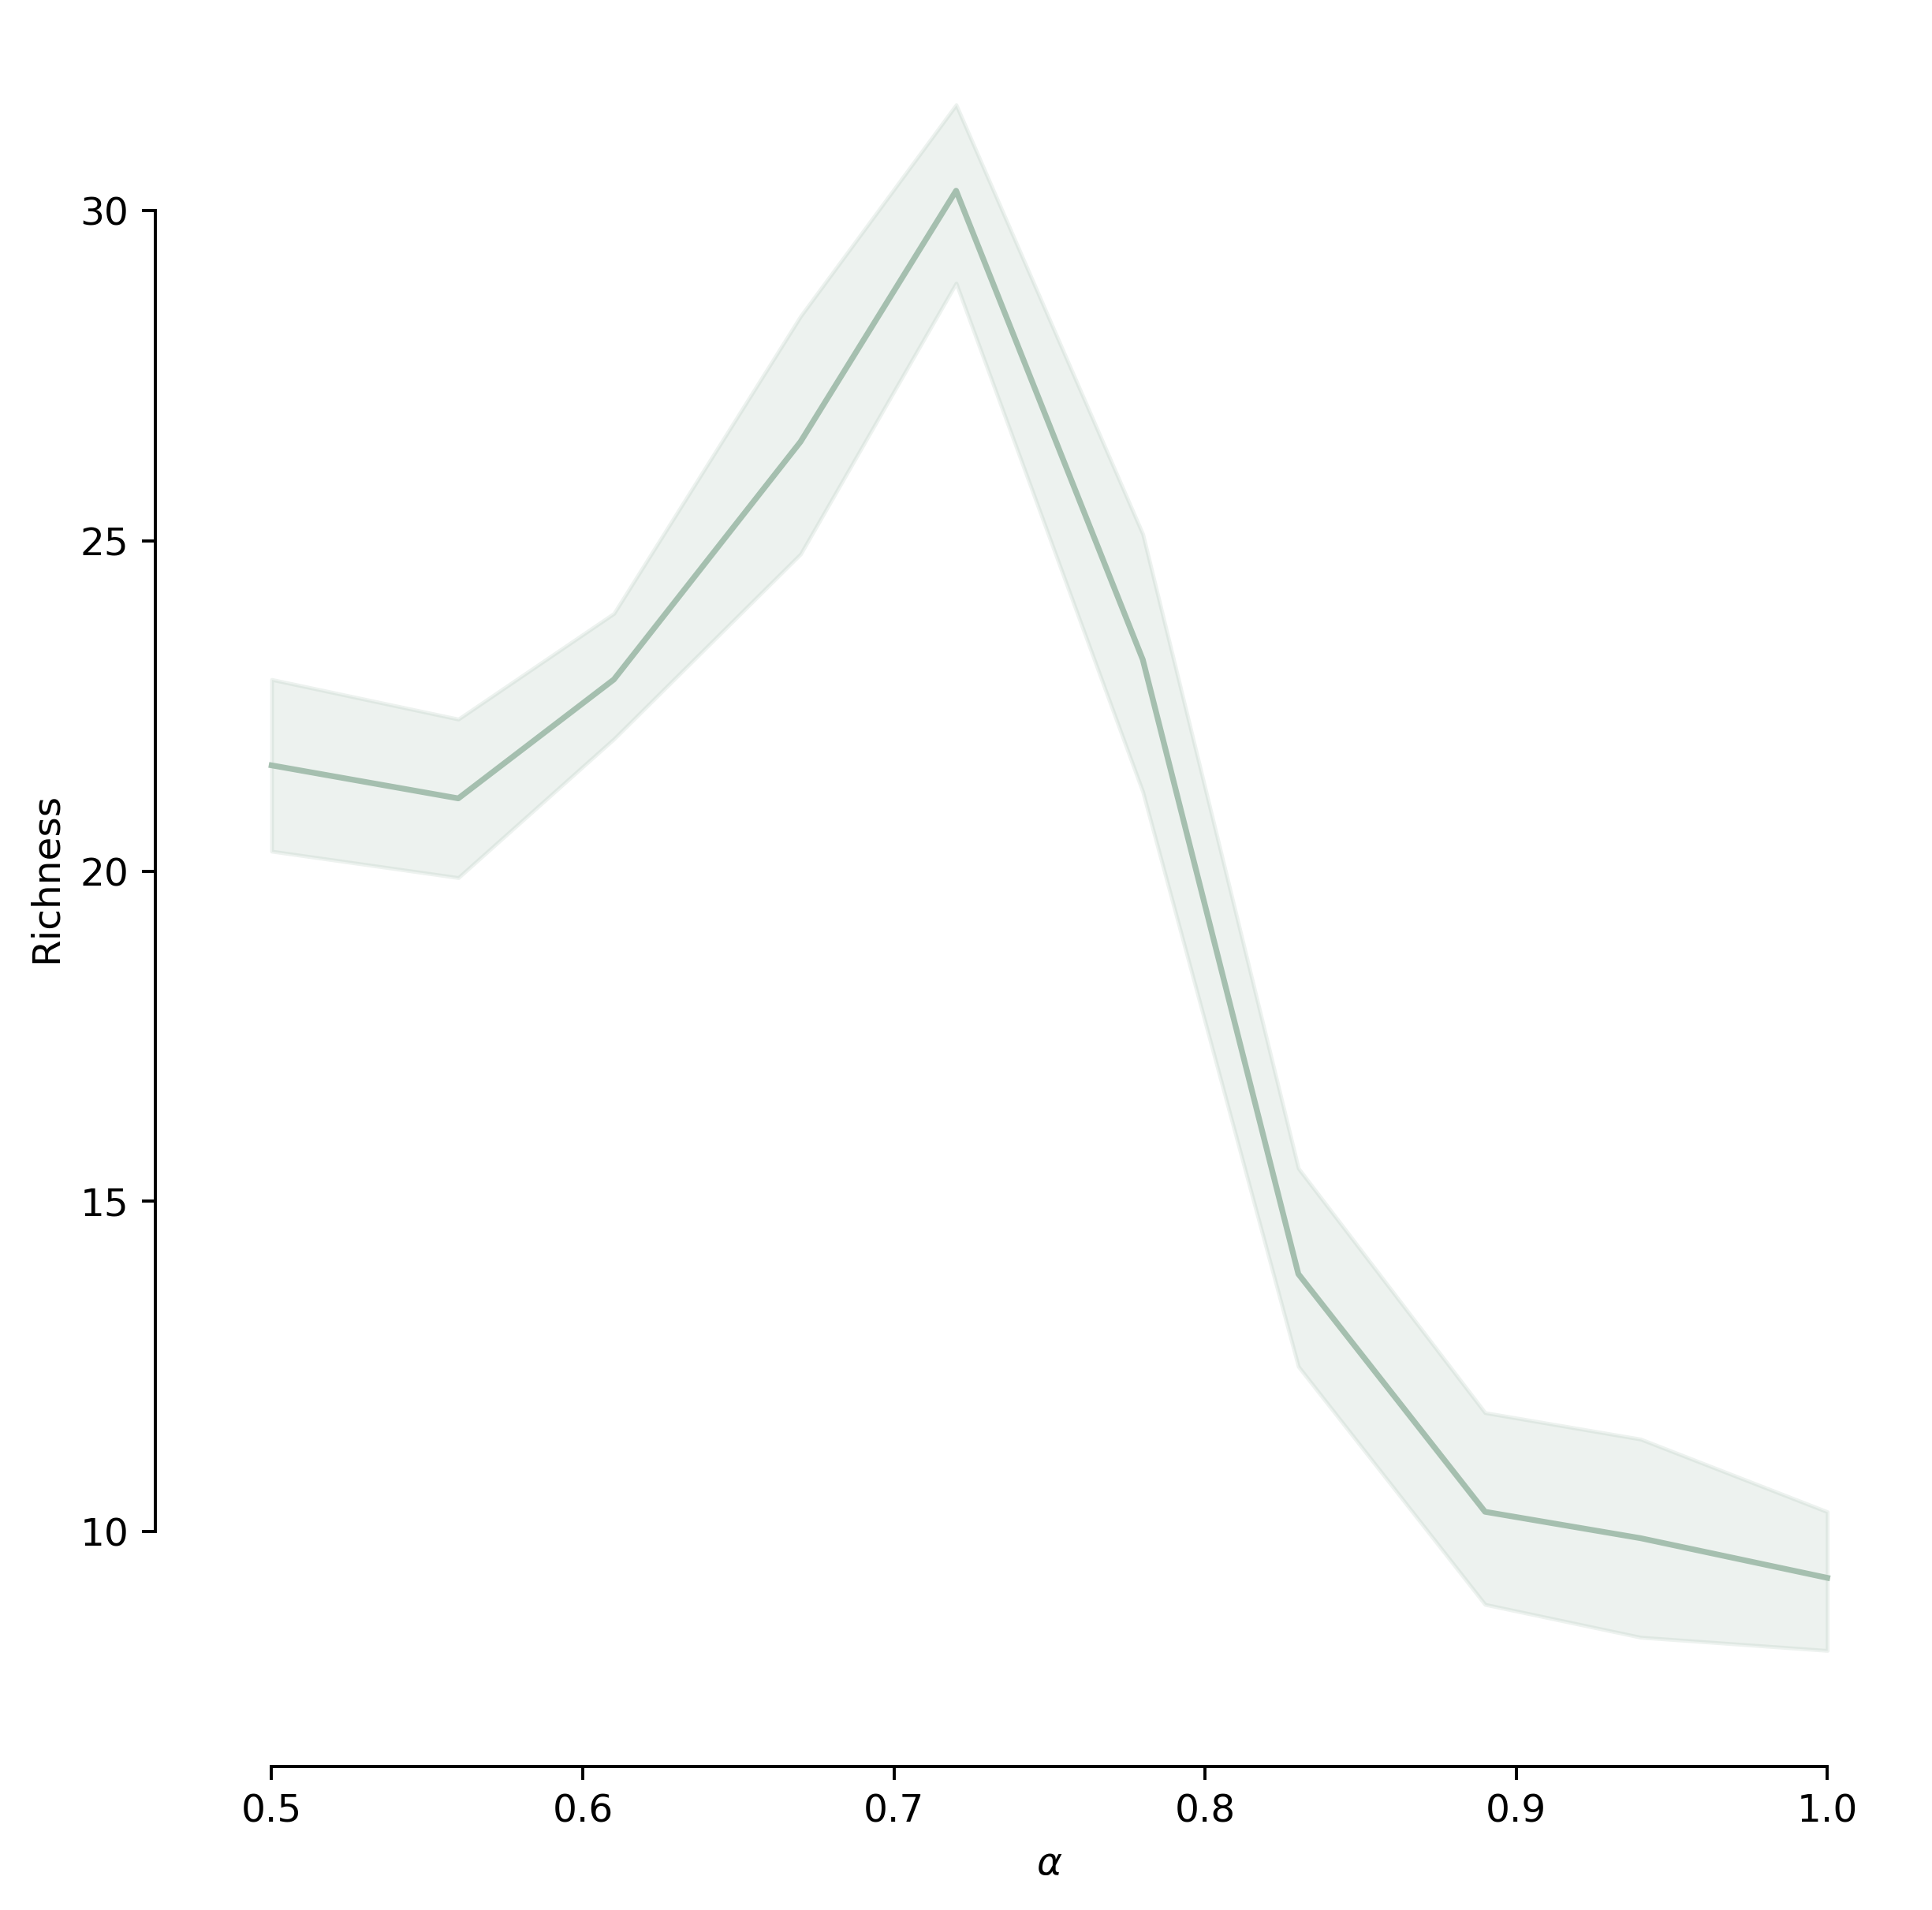

In [204]:
finaldf = all_pair_df_alphas[all_pair_df_alphas['t'] == all_pair_df_alphas['t'].iloc[-1]]
finaldf['scaling exponents'] = [finaldf['scaling exponents'].iloc[i][0] for i in range(100)]
finaldf
f = plt.figure(figsize=(8, 8), dpi=350)
sns.lineplot(data=finaldf, x='scaling exponents', y='Coexsistence', color='#A5BFAF')
sns.despine(offset=10, trim=True)
plt.xlabel('$\\alpha$')
plt.ylabel('Richness')
f.savefig('..\Results\Figures\\varied_alpha.png')

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=350)
axes = axes.flatten(order='F')
new_df = [dfs[0], dfs[1], dfs[4], dfs[5], dfs[8], dfs[9]]

for i in range(len(axes)):
    sns.lineplot(x='t', y="Coexsistence", data=new_df[i], ax=axes[i], color='#A5BFAF')
    alpha, _ = new_df[i]['scaling exponents'].iloc[0]
    axes[i].set_title(f'$\\alpha={alpha}$')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Richness')
    sns.despine(offset=10, trim=True, ax=axes[i])

fig.subplots_adjust(hspace=0.3)
fig.savefig('..\Results\Figures\\alpha_rich_traj.png')